# Modello di previsione per il mercato immobiliare

L'analisi presente nel seguente notebook si propone di trovare il modello di regressione lineare più adatto alla realizzazione di previsioni di prezzo del mercato immobiliare, riducendo il rischio di overfitting e garantendo una discreta capacità di generalizzazione del modello.

Nello svolgimento dell'analisi, ciò che viene richiesto è di partire da un dataset assegnato (https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv), e trattarlo opportunamente ai fini dell'utilizzo dei modelli di regressione lineare.

Viene, inoltre, richiesto di implementare e addestrare diversi modelli di regressione (Ridge, Lasso ed Elastic Net Regression) per valutare le performance dei vari modelli e confrontarne la bontà dei risultati (anche graficamente).

## Analisi EDA sul dataset
Di seguito si riportano i passaggi realizzati per l'analisi esplorativa del dataset, che ha le seguenti caratteristiche:

- __Price__: il prezzo, il target da prevedere
- __Area__: superficie dell’immobile
- __Bedrooms__: numero di camere da letto
- __Bathrooms__: numero di bagni
- __Stories__: numero di piani
- __Mainroad__: vale 1 se l’immobile affaccia su una strada principale, 0 altrimenti
- __guestroom__: vale 1 se l’immobile ha una stanza degli ospiti, 0 altrimenti
- __basement__: vale 1 se l’immobile ha un seminterrato, 0 altrimenti
- __hotwaterheating__: vale 1 se l’immobile ha una caldaia, 0 altrimenti
- __airconditioning__: vale 1 se l’immobile ha l’aria condizionata, 0 altrimenti
- __parking__: numero di parcheggi
- __prefarea__: vale 1 se l’immobile è in una zona prestigiosa, 0 altrimenti
- __Furnishingstatus__: vale 0 se l’immobile non è arredato, 1 se è parzialmente arredato, 2 se è completamente arredato

In [1]:
dataset_url = r"https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"

In [2]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_validate, cross_val_predict, KFold

In [4]:
df = pd.read_csv(dataset_url)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


Si vede come nel dataset non sono presenti valori null, e come le variabili categoriche siano già convertite in interi.
Si passa ad analizzare eventuali correlazioni delle diverse feature con la variabile target.

### Analisi Correlazione tra variabili e target

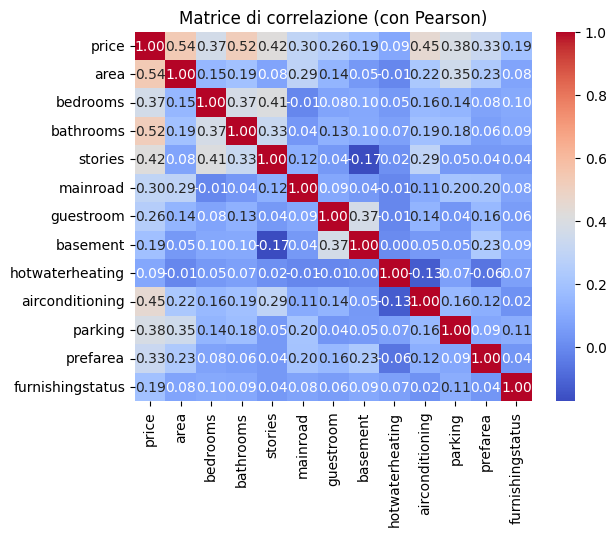

In [6]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione (con Pearson)")
plt.show()

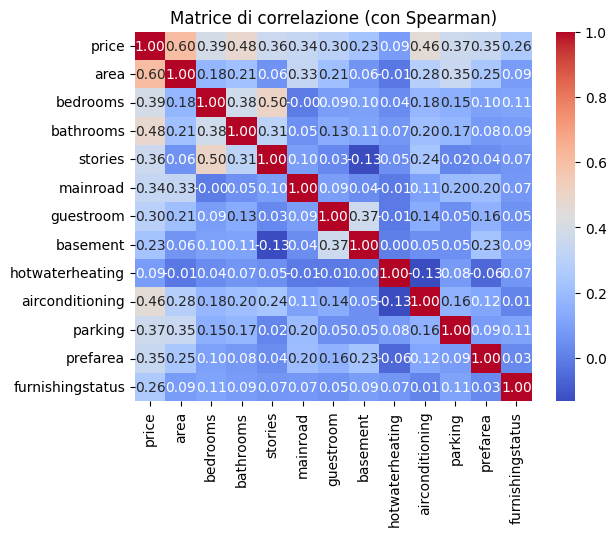

In [7]:
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione (con Spearman)")
plt.show()

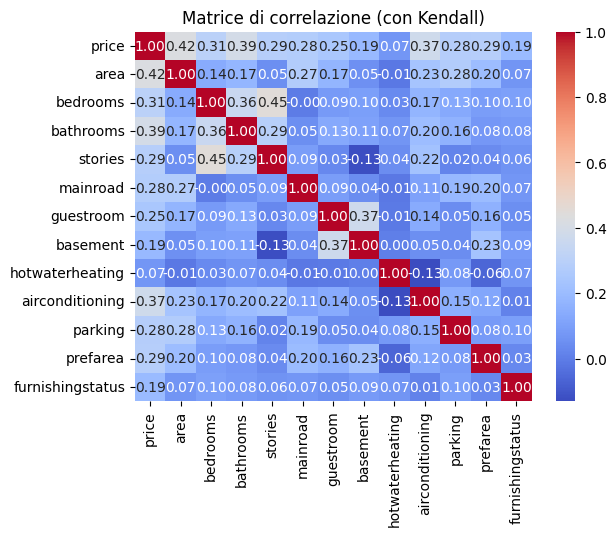

In [8]:
sns.heatmap(df.corr(method="kendall"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione (con Kendall)")
plt.show()

Dalla matrice di correlazione (calcolata con tutti e 3 i coefficienti - Pearson, Kendall e Spearman -), si può vedere come la variabile __hotwaterheating__ è la meno correlata al target, quindi si può escludere dal dataset per ridurne la dimensionalità.

Valori molto bassi di correlazione si riscontrano pure per le variabili __Furnishingstatus__ e __basement__ la correlazione con il target risulta bassa: a questo proposito si possono considerare come variabili da rimuovere.

La rimozione delle 3 variabili aiuta nella riduzione della dimensionalità del dataset, permettendo al modello di lavorare solo con le feature che portano un maggior contenuto informativo ai fini della previsione.

### Analisi relazione tra variabili e target

 Si analizza adesso la distribuzione delle variabili rispetto al target, mediante la composizione degli scatter plot.

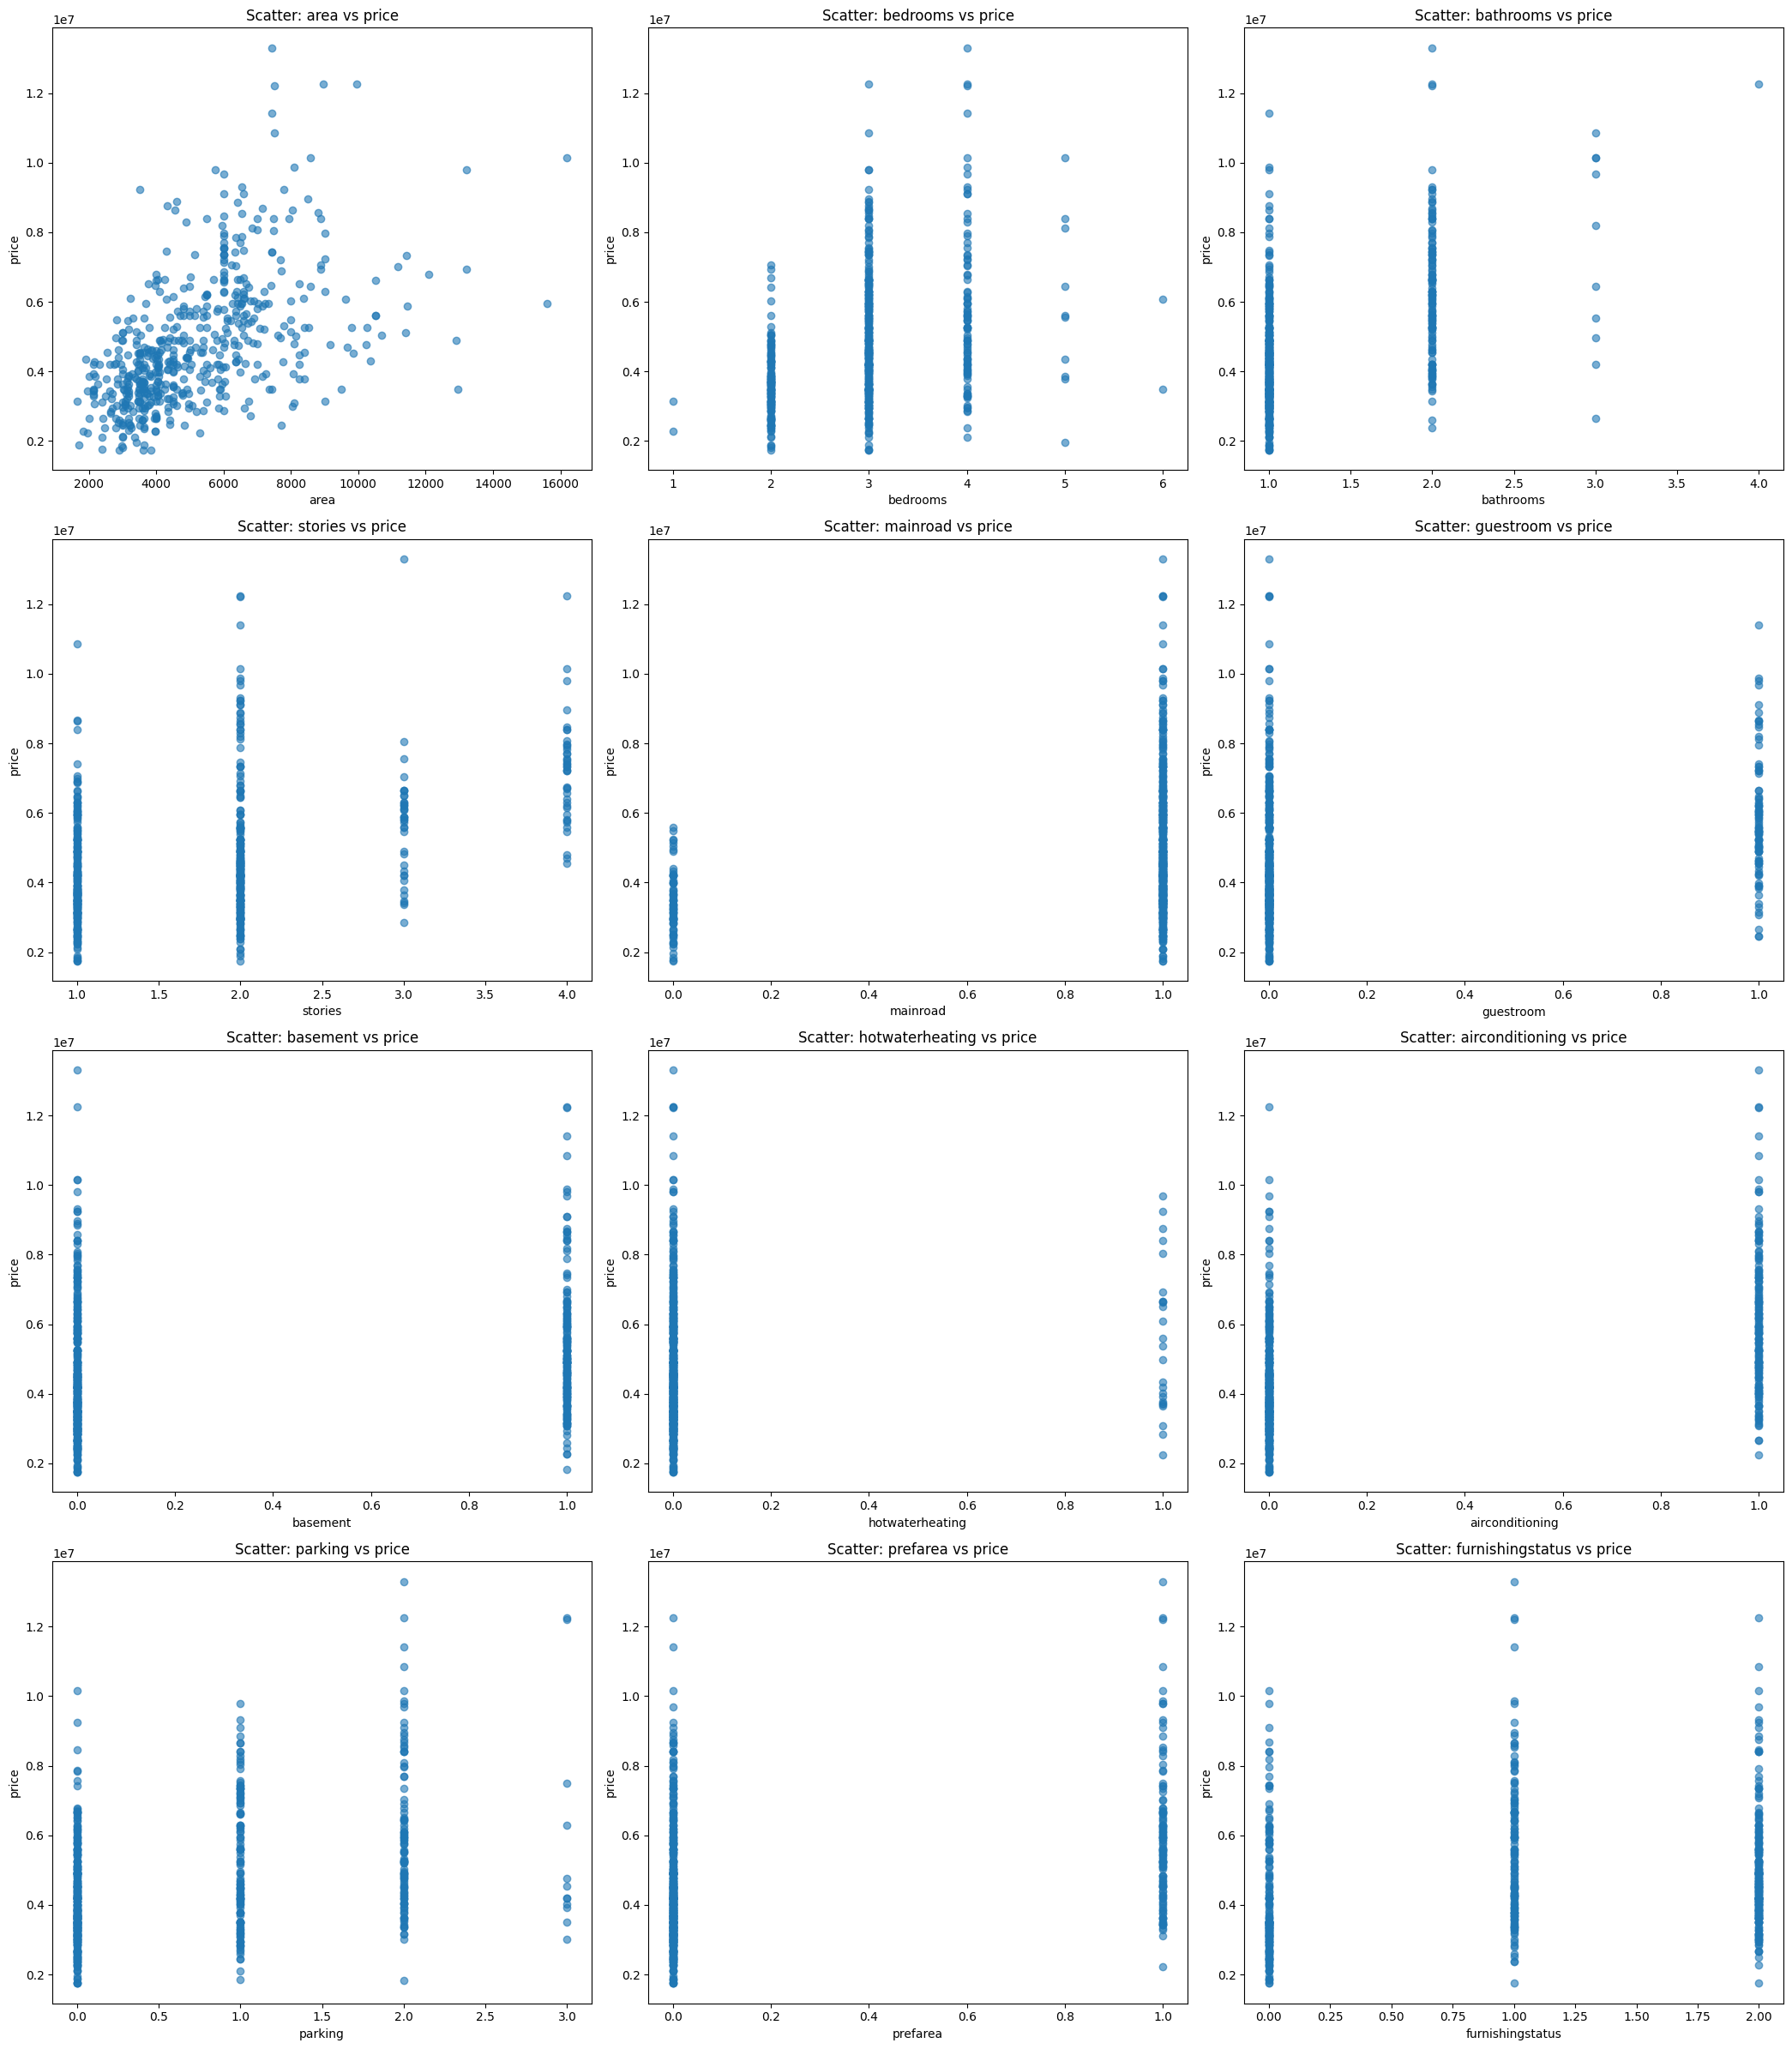

In [9]:
features = df.drop('price', axis = 1).columns
target_col = 'price'

variables = len(features)
num_cols = 3
num_rows = int(variables / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=[num_cols*7, num_rows*6])
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].scatter(df[feature], df[target_col], alpha = 0.6)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_col)
    axes[i].set_title(f'Scatter: {feature} vs {target_col}')

plt.tight_layout()
plt.show()

Dagli scatter plot realizzati si può vedere come le relazioni tra le variabili ed il target non siano propriamente lineari.
Questo potrebbe portare a dei problemi nell'interpretazione dei dati da parte dei modelli lineari.
Come potenziale misura di mitigazione, si potrebbe pensare di usare come target il logaritmo del prezzo (log(price)), per provare a linearizzare il legame delle feature con il target aiutando i modelli nella previsione.

In [10]:
df['log_price'] = df['price'].map(lambda x: math.log(x))

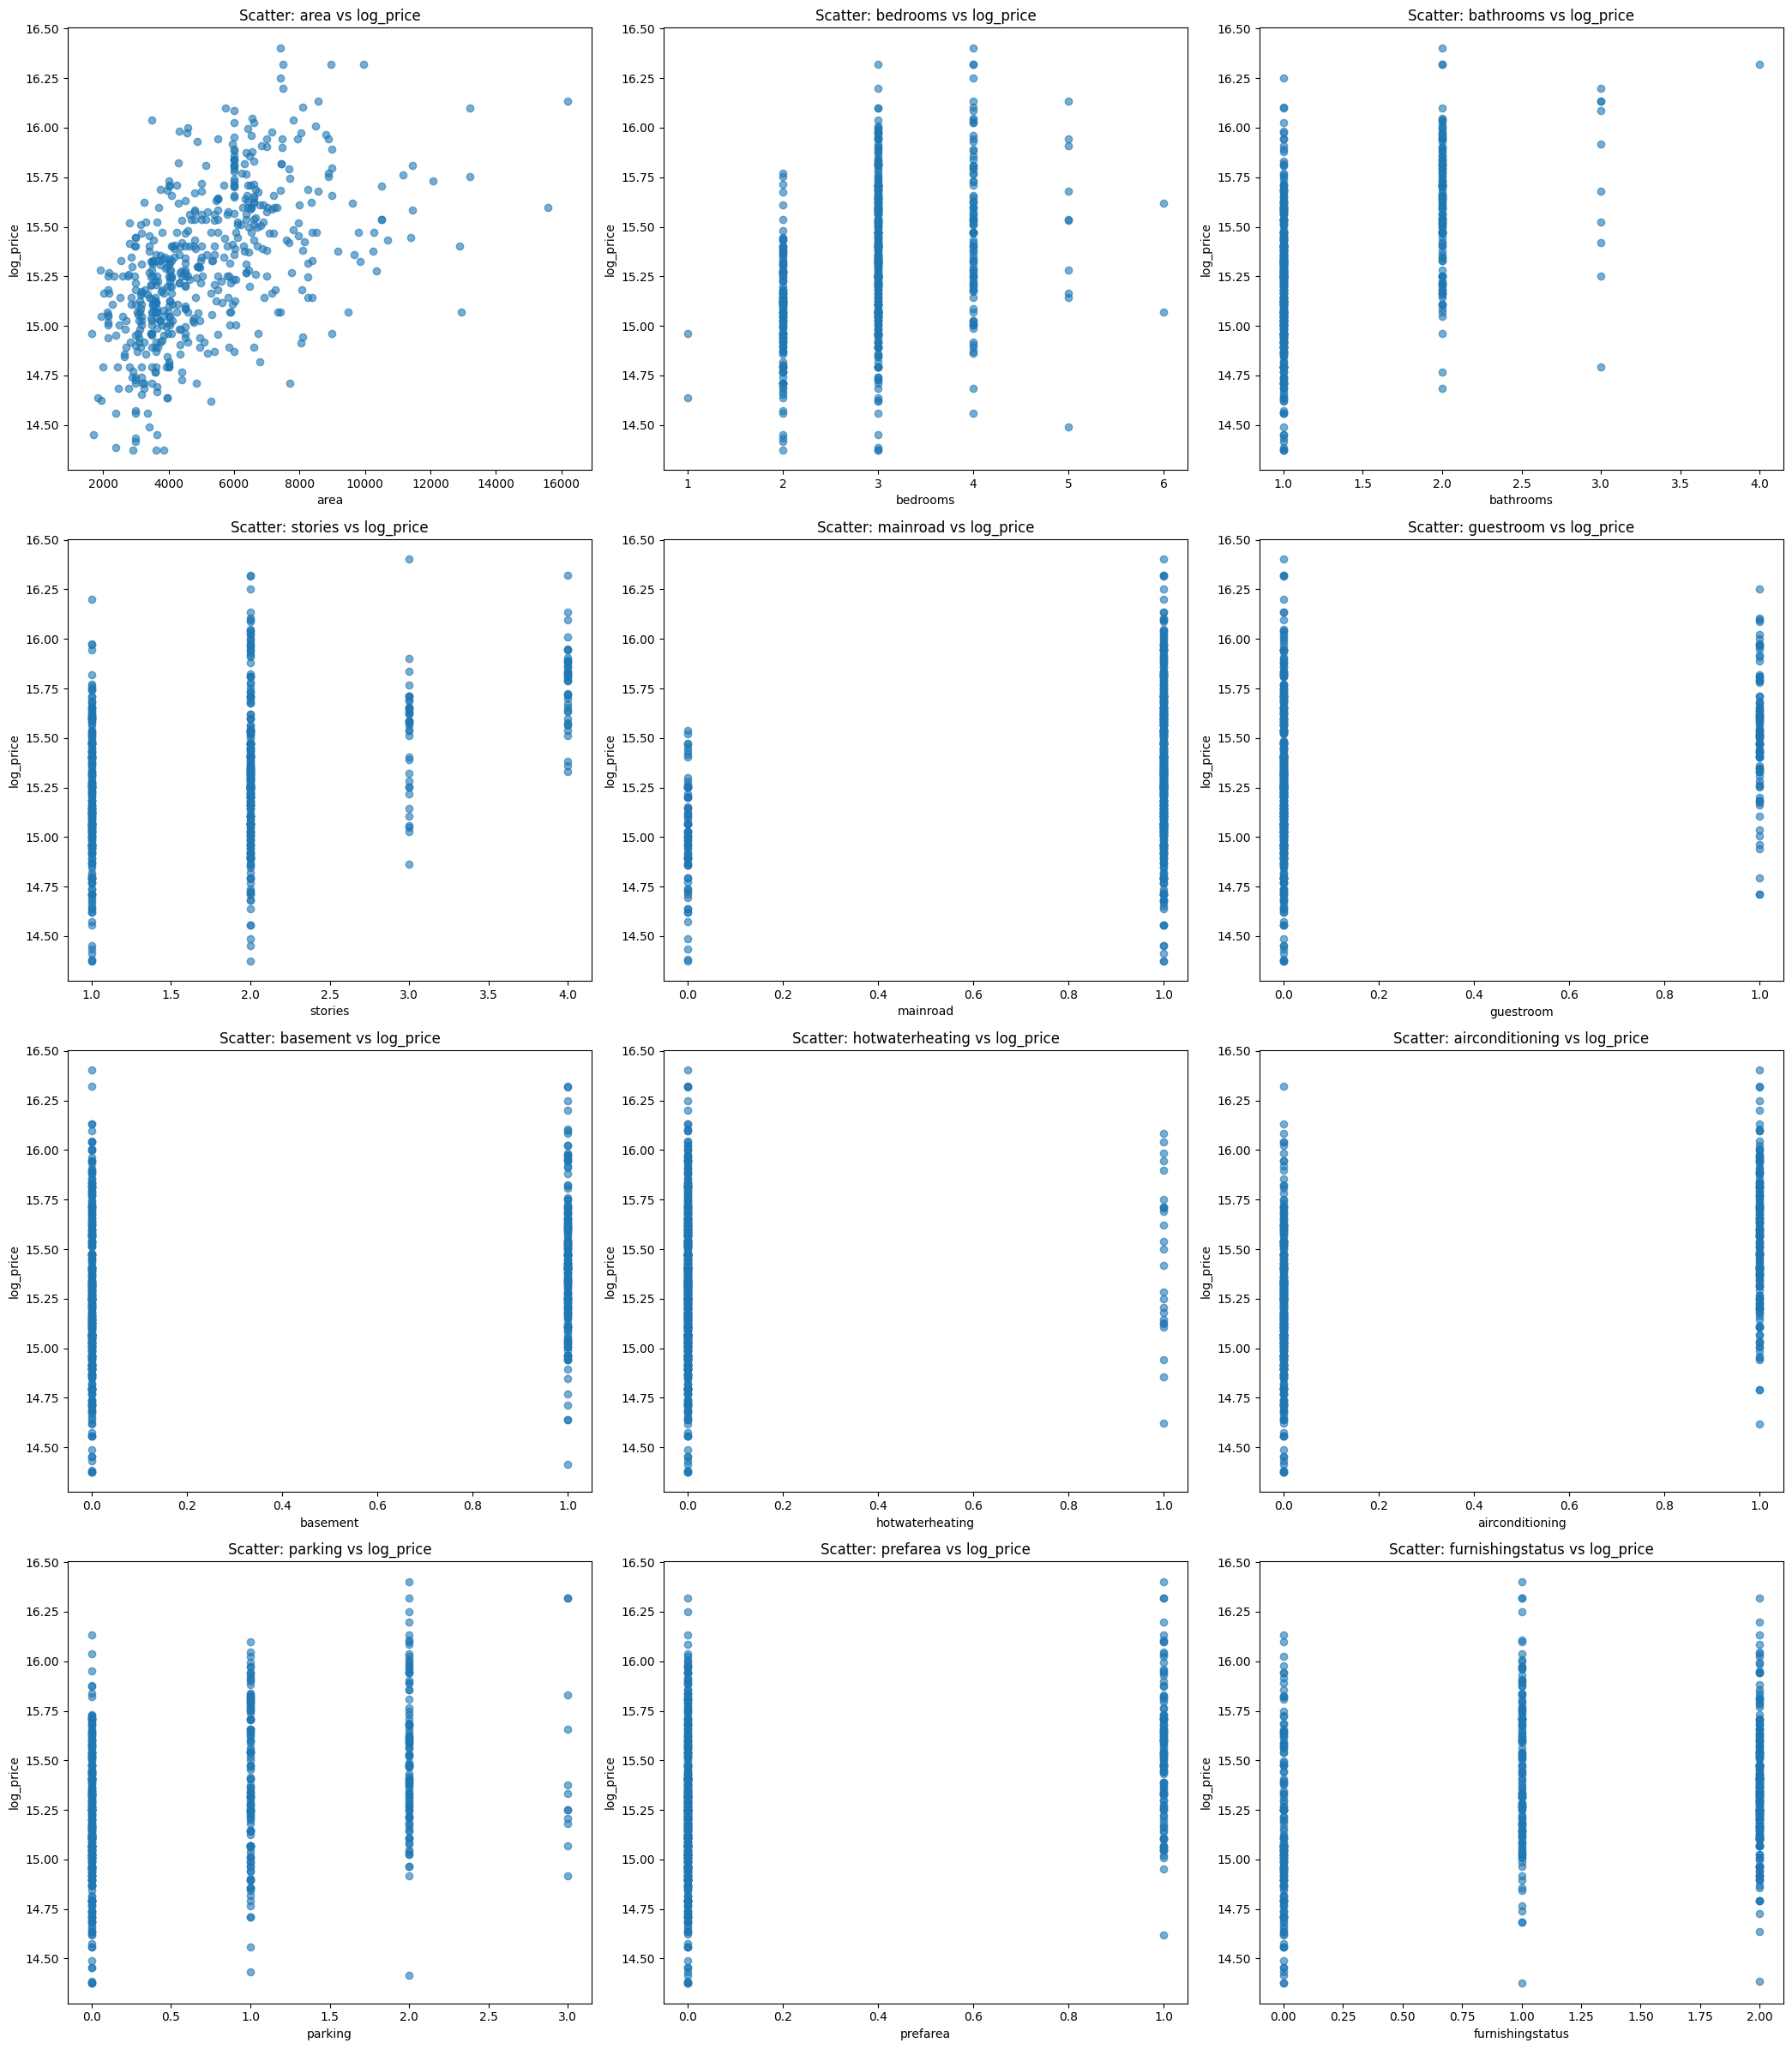

In [11]:
features = df.drop(['price', 'log_price'], axis = 1).columns
target_col = 'log_price'

variables = len(features)
num_cols = 3
num_rows = int(variables / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=[num_cols*7, num_rows*6])
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].scatter(df[feature], df[target_col], alpha = 0.6)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_col)
    axes[i].set_title(f'Scatter: {feature} vs {target_col}')

plt.tight_layout()
plt.show()

Si riscontra un cambiamento nella distribuzione, ma di fatto non si è riusciti ad ottenere una maggiore linearità dei legami tra feature e target.
Vista però la presenza di record con prezzi molto alti, l'utilizzo della log(price) può diminuire l'influenza di questi outliers ed aiutare la previsione del modello.

### Valutazione circa la necessità di effettuare uno scaling delle feature

Si analizza adesso la "magnitudo" delle diverse variabili per capire se può valere la pena effettuare un'operazione di standardizzazione delle feature.

In [12]:
min_max_values = df.describe().loc[['min','max']].T
min_max_values

,min,max
price,1.750000e+06,1.330000e+07
area,1.650000e+03,1.620000e+04
bedrooms,1.000000e+00,6.000000e+00
bathrooms,1.000000e+00,4.000000e+00
stories,1.000000e+00,4.000000e+00
mainroad,0.000000e+00,1.000000e+00
guestroom,0.000000e+00,1.000000e+00
basement,0.000000e+00,1.000000e+00
hotwaterheating,0.000000e+00,1.000000e+00
airconditioning,0.000000e+00,1.000000e+00


Le varie feature hanno dei range di valori simili, però non completamente omogenei quindi effettuare una standardizzazione dei valori può sicuramente aiutare il modello di regressione.
Per quanto riguarda i valori dei due possibili target (price e la log(price)), si vede come usando il logaritmo si riduce sensibilmente la "Magnitudo" del target.

### Esiti dell'analisi EDA

Quello che si può evincere dall'analisi appena effettuata è che il dataset risulta già trattato in termini di presenza di valori null o missing, conversione delle variabili categoriche in numeriche.

Sono state individuate le 3 variabili con correlazione più bassa rispetto al target, che si rimuoveranno per ridurre la dimensionalità del dataset, essendo variabili dal basso contenuto informativo.

Inoltre, è opportuno realizzare una standardizzazione delle feature per aiutare l'apprendimento del modello.

Si è visto come le relazioni tra le variabili ed il target non siano lineari neanche raffrontando le feature alla log(price): vista la richiesta di utilizzare modelli lineari, è verosimile aspettarsi delle performance non ottimali. In prima istanza si procederà ad operare considerando il prezzo come target, successivamente se le performance dei modelli non fossero adeguate, si proverà ad usare la log(price).

## Preprocessing del dataset

Si procede a realizzare i passaggi per il pre-processing del dataset, che consisteranno in:

- eliminare le feature che sono state identificate come meno correlate al target
- realizzare una standardizzazione delle feature;

In [13]:
X = df.drop(['price', 'furnishingstatus', 'basement', 'hotwaterheating', 'log_price'], axis=1).values
y = df['price'].values

In [14]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [15]:
X.shape

(545, 9)

In [16]:
y.shape

(545,)

## Implementazione dei modelli

Di seguito si realizza l'implementazione dei modelli Ridge, Lasso ed Elastic Net utilizzando la cross validation per la definizione dei risultati dei modelli (come da richiesta progettuale).

### Regressione Lasso

Si parte dalla regressione Lasso, valutando i risultati per diversi valori del parametro lambda.

In [17]:
scoring_metrics = ['neg_mean_squared_error', 'r2']

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10, 100]

In [18]:
lasso_results = []

for a in alphas:

    lasso = Lasso(alpha = a)

    results = cross_validate(lasso, X, y, scoring=scoring_metrics, cv=5, return_train_score=True)

    lasso_results.append({
        "alpha":a,
        "Train MSE": -results['train_neg_mean_squared_error'].mean(),
        "Test MSE": -results['test_neg_mean_squared_error'].mean(),
        "Train R2": results['train_r2'].mean(),
        "Test R2": results['test_r2'].mean()
    })


In [19]:
df_lasso = pd.DataFrame(data=lasso_results)
df_lasso.head(13)

,alpha,Train MSE,Test MSE,Train R2,Test R2
0,0.1,1.133845e+12,2.105373e+12,0.6344,-9.794580
1,0.2,1.133845e+12,2.105374e+12,0.6344,-9.794580
2,0.3,1.133845e+12,2.105375e+12,0.6344,-9.794580
3,0.4,1.133845e+12,2.105375e+12,0.6344,-9.794579
4,0.5,1.133845e+12,2.105375e+12,0.6344,-9.794578
5,0.6,1.133845e+12,2.105376e+12,0.6344,-9.794577
6,0.7,1.133845e+12,2.105376e+12,0.6344,-9.794576
7,0.8,1.133845e+12,2.105377e+12,0.6344,-9.794575
8,0.9,1.133845e+12,2.105377e+12,0.6344,-9.794574
9,1.0,1.133845e+12,2.105378e+12,0.6344,-9.794574


Da una prima occhiata si può vedere come le metriche del modello siano abbastanza scarse sul dataset a prescindere dal parametro alpha considerato, riportando sia un errore molto elevato che un parametro R2 negativo.

### Regressione Ridge

Si procede ad implementare un modello di regressione Ridge, analogamente a quanto fatto con la regressione Lasso considerando gli stessi valori di alpha e le stesse metriche di errore.

In [20]:
ridge_results = []

for a in alphas:

    ridge = Ridge(alpha = a)

    results = cross_validate(ridge, X, y, scoring=scoring_metrics, cv=5, return_train_score=True)

    ridge_results.append({
        "alpha":a,
        "Train MSE": -results['train_neg_mean_squared_error'].mean(),
        "Test MSE": -results['test_neg_mean_squared_error'].mean(),
        "Train R2": results['train_r2'].mean(),
        "Test R2": results['test_r2'].mean()
    })

In [21]:
df_ridge = pd.DataFrame(data=ridge_results)
df_ridge.head(13)

,alpha,Train MSE,Test MSE,Train R2,Test R2
0,0.1,1.133845e+12,2.105617e+12,0.634400,-9.793879
1,0.2,1.133845e+12,2.105860e+12,0.634400,-9.793177
2,0.3,1.133845e+12,2.106104e+12,0.634400,-9.792476
3,0.4,1.133846e+12,2.106347e+12,0.634400,-9.791775
4,0.5,1.133846e+12,2.106591e+12,0.634400,-9.791075
5,0.6,1.133846e+12,2.106834e+12,0.634400,-9.790376
6,0.7,1.133847e+12,2.107077e+12,0.634400,-9.789677
7,0.8,1.133847e+12,2.107320e+12,0.634399,-9.788978
8,0.9,1.133848e+12,2.107563e+12,0.634399,-9.788280
9,1.0,1.133848e+12,2.107806e+12,0.634399,-9.787583


Anche per questo modello le performance sono non ottimali, sempre indipendetemente al valore di alpha considerato e molto simili a quanto visto con il modello Lasso.

### Regolarizzazione Elastic Net

Si passa adesso all'implementazione della Elastic Net Regression, utilizzando sempre le stesse metriche di errore, con la differenza che dovranno essere definiti diversi valori del parametro L1 Ratio.

In [22]:
l1_values = [0.1, 0.3, 0.5, 0.7, 0.9]

elastic_results = []

for a in alphas:
    for l1 in l1_values:
        elastic = ElasticNet(alpha = a, l1_ratio = l1)
        results = cross_validate(elastic, X, y, scoring=scoring_metrics, cv=5, return_train_score=True)

        elastic_results.append({
            "alpha":a,
            "L1 Ratio": l1,
            "Train MSE": -results['train_neg_mean_squared_error'].mean(),
            "Test MSE": -results['test_neg_mean_squared_error'].mean(),
            "Train R2": results['train_r2'].mean(),
            "Test R2": results['test_r2'].mean()
        })

In [23]:
df_elastic = pd.DataFrame(data=elastic_results)
df_elastic

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2
0,0.1,0.1,1.137738e+12,2.195957e+12,0.633005,-9.556489
1,0.1,0.3,1.136268e+12,2.176615e+12,0.633528,-9.603321
2,0.1,0.5,1.135118e+12,2.156854e+12,0.633939,-9.653467
3,0.1,0.7,1.134318e+12,2.136639e+12,0.634228,-9.707110
4,0.1,0.9,1.133899e+12,2.115929e+12,0.634380,-9.764453
5,0.2,0.1,1.147691e+12,2.278554e+12,0.629533,-9.382501
6,0.2,0.3,1.142652e+12,2.242673e+12,0.631280,-9.452828
7,0.2,0.5,1.138584e+12,2.205482e+12,0.632706,-9.534262
8,0.2,0.7,1.135651e+12,2.166790e+12,0.633748,-9.627968
9,0.2,0.9,1.134059e+12,2.126349e+12,0.634322,-9.735305


Anche in questo caso, si può notare come le performance siano abbastanza scarse ed in linea con gli altri modelli.

## Valutazione delle performance e visualizzazione risultati

Di seguito si procede a svolgere delle analisi di confronto tra i modelli addestrati per verificare quale dei 3 ha performato meglio sul dataset a disposizione.

Si procederà a valutare i parametri dei modelli per cui si sono le migliori metriche: su questi poi verrà realizzato il confronto delle performance.

In [24]:
df_lasso[(df_lasso['Test R2'] == df_lasso['Test R2'].max()) | (df_lasso['Test MSE'] == df_lasso['Test MSE'].min())]

,alpha,Train MSE,Test MSE,Train R2,Test R2
0,0.1,1.133845e+12,2.105373e+12,0.6344,-9.794580
11,100.0,1.133845e+12,2.105841e+12,0.6344,-9.793759


In [25]:
df_ridge[(df_ridge['Test R2'] == df_ridge['Test R2'].max()) | (df_ridge['Test MSE'] == df_ridge['Test MSE'].min())]

,alpha,Train MSE,Test MSE,Train R2,Test R2
0,0.1,1.133845e+12,2.105617e+12,0.634400,-9.793879
11,100.0,1.155052e+12,2.321237e+12,0.627009,-9.309536


In [26]:
df_elastic[(df_elastic['Test R2'] == df_elastic['Test R2'].max()) | (df_elastic['Test MSE'] == df_elastic['Test MSE'].min())]

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2
4,0.1,0.9,1.133899e+12,2.115929e+12,0.634380,-9.764453
36,0.8,0.3,1.225338e+12,2.573124e+12,0.603709,-9.113273


Per fare un'analisi comparativa tra le "migliori" versioni dei modelli, si sceglie di prendere, per ciascuno di essi, i valori dei parametri che consentono di minimizzare il valore del MSE sul dataset di test.

In [27]:
df_elastic['model_name'] = 'Elastic Net, L1 Ratio = 0.9, Alpha = 0.1'
df_ridge['model_name'] = 'Ridge, Alpha = 0.1'
df_lasso['model_name'] = 'Lasso, Alpha = 0.1'

In [28]:
df_lasso_best = df_lasso[df_lasso['Test MSE'] == df_lasso['Test MSE'].min()]
df_ridge_best = df_ridge[df_ridge['Test MSE'] == df_ridge['Test MSE'].min()]
df_elastic_best = df_elastic[df_elastic['Test MSE'] == df_elastic['Test MSE'].min()]

In [29]:
df_evaluation = pd.concat([df_elastic_best, df_lasso_best, df_ridge_best])
df_evaluation.head()

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2,model_name
4,0.1,0.9,1.133899e+12,2.115929e+12,0.63438,-9.764453,"Elastic Net, L1 Ratio = 0.9, Alpha = 0.1"
0,0.1,NaN,1.133845e+12,2.105373e+12,0.63440,-9.794580,"Lasso, Alpha = 0.1"
0,0.1,NaN,1.133845e+12,2.105617e+12,0.63440,-9.793879,"Ridge, Alpha = 0.1"


### Confronto valori MSE e R2

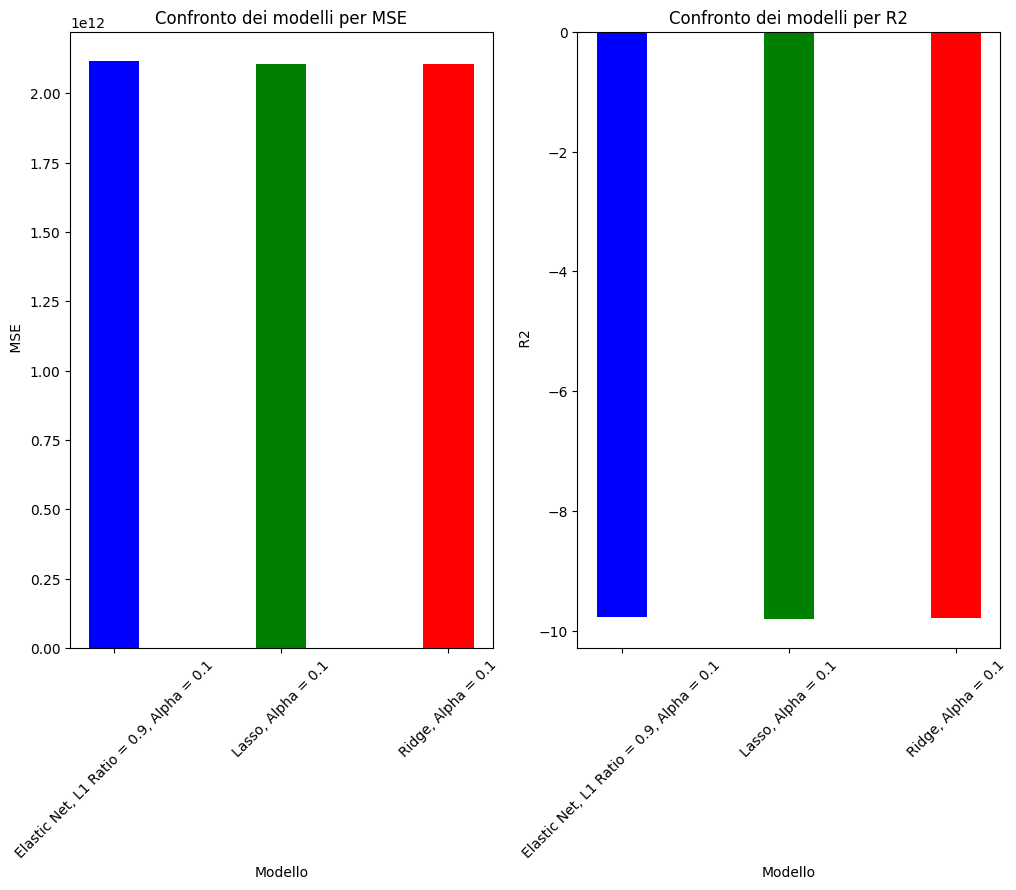

In [30]:
x = df_evaluation['model_name']
columns = df_evaluation[['Test MSE', 'Test R2']].columns
colors = ['blue', 'green', 'red']

fig, axes = plt.subplots(1, 2, figsize=[12, 8])
axes = axes.flatten()
for i, column in enumerate(columns):
    axes[i].bar(x, df_evaluation[column].values, width = 0.3, color = colors, label = column.strip('Test '))
    axes[i].set_xlabel('Modello')
    axes[i].set_ylabel(column.strip('Test'))
    axes[i].set_title(f"Confronto dei modelli per {column.strip('Test ')}")
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

Rispetto alle due metriche considerate, già si può vedere come i modelli abbiano dei risultati simili e non performino bene.

### Analisi della distribuzione dei residui

Di seguito si passa ad analizzare la distribuzione dei residui dei 3 modelli.

In [31]:
#si definiscono i modelli con i parametri che ne massimizzano le performance
lasso_best = Lasso(alpha=0.1)
ridge_best = Ridge(alpha=0.1)
elastic_best = ElasticNet(alpha=0.1, l1_ratio=0.9)

In [32]:
y_pred_lasso = cross_val_predict(lasso_best, X, y, cv=5)
residui_lasso = y - y_pred_lasso

In [33]:
y_pred_ridge = cross_val_predict(ridge_best, X, y, cv=5)
residui_ridge = y - y_pred_ridge

In [34]:
y_pred_elastic = cross_val_predict(elastic_best, X, y,cv=5)
residui_elastic = y - y_pred_elastic

In [35]:
diagram_dict = {
    "Lasso": [y_pred_lasso, residui_lasso],
    "Ridge": [y_pred_ridge, residui_ridge],
    "Elastic Net": [y_pred_elastic, residui_elastic]
}

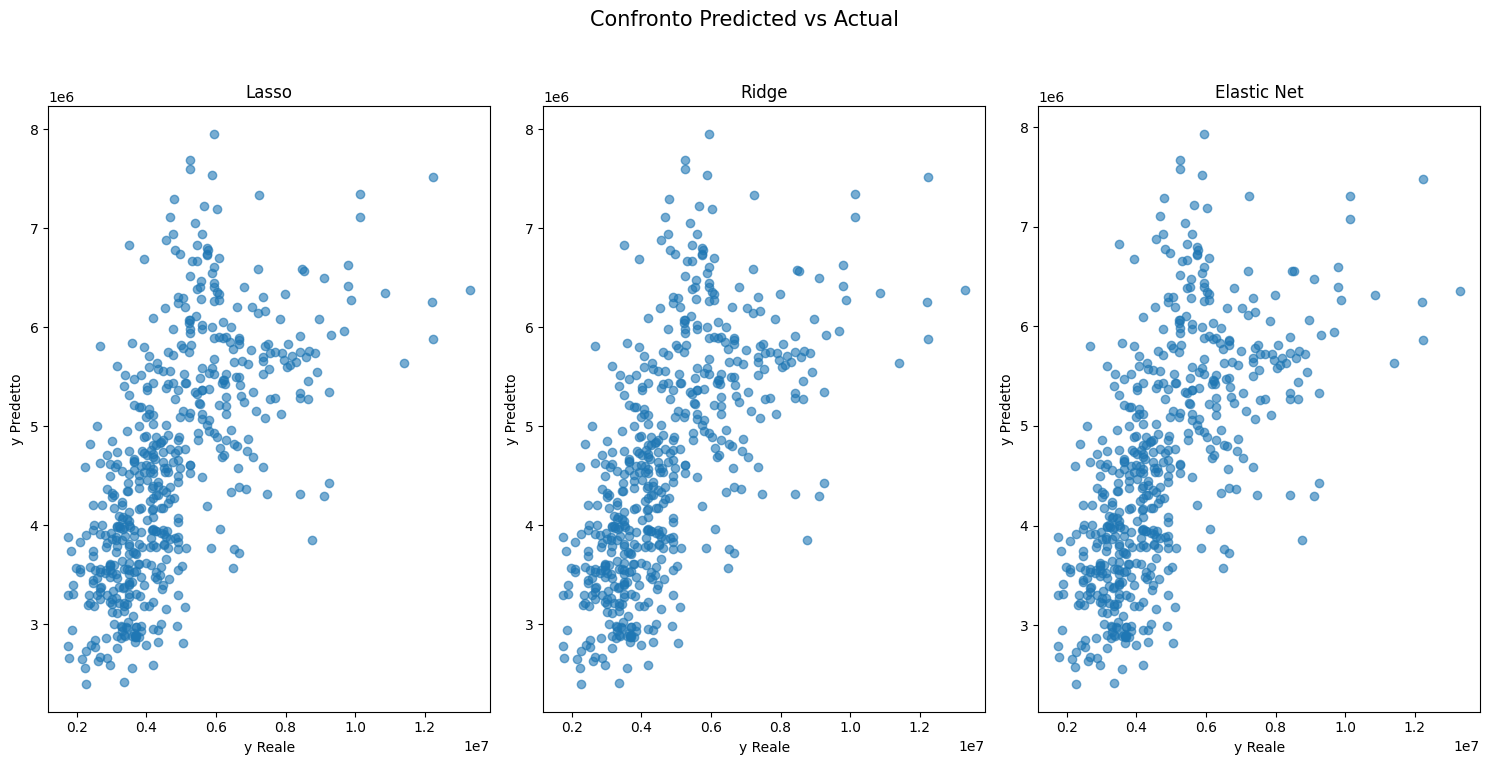

In [36]:
fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()

for i, model in enumerate(diagram_dict.keys()):
    axes[i].scatter(x=y, y=diagram_dict[model][0], alpha=0.6)
    axes[i].set_xlabel("y Reale")
    axes[i].set_ylabel("y Predetto")
    axes[i].set_title(f"{model}")

fig.suptitle("Confronto Predicted vs Actual", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

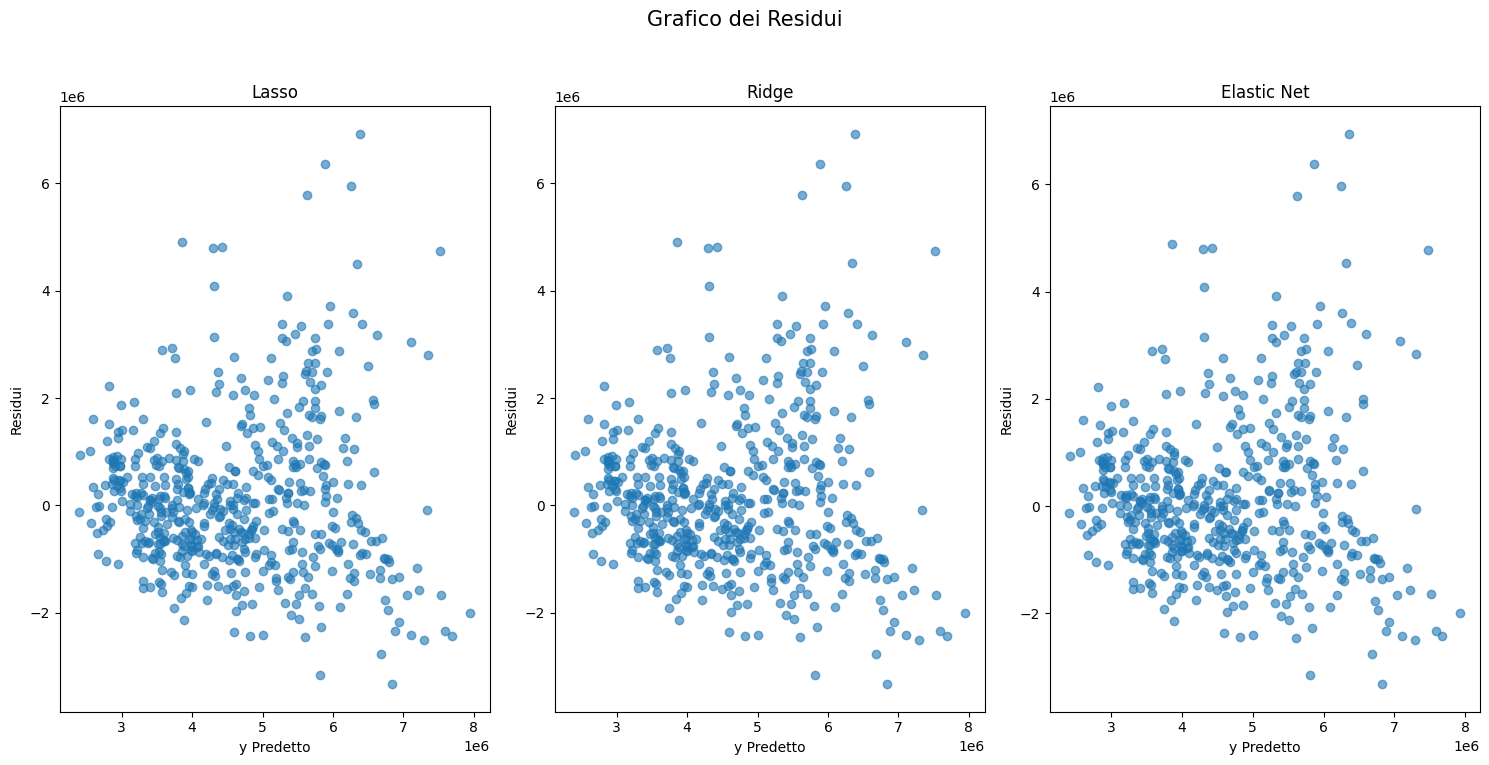

In [37]:
fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()


for i, model in enumerate(diagram_dict.keys()):
    axes[i].scatter(x=diagram_dict[model][0], y=diagram_dict[model][1], alpha=0.6)
    axes[i].set_xlabel("y Predetto")
    axes[i].set_ylabel("Residui")
    axes[i].set_title(f"{model}")

fig.suptitle("Grafico dei Residui", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

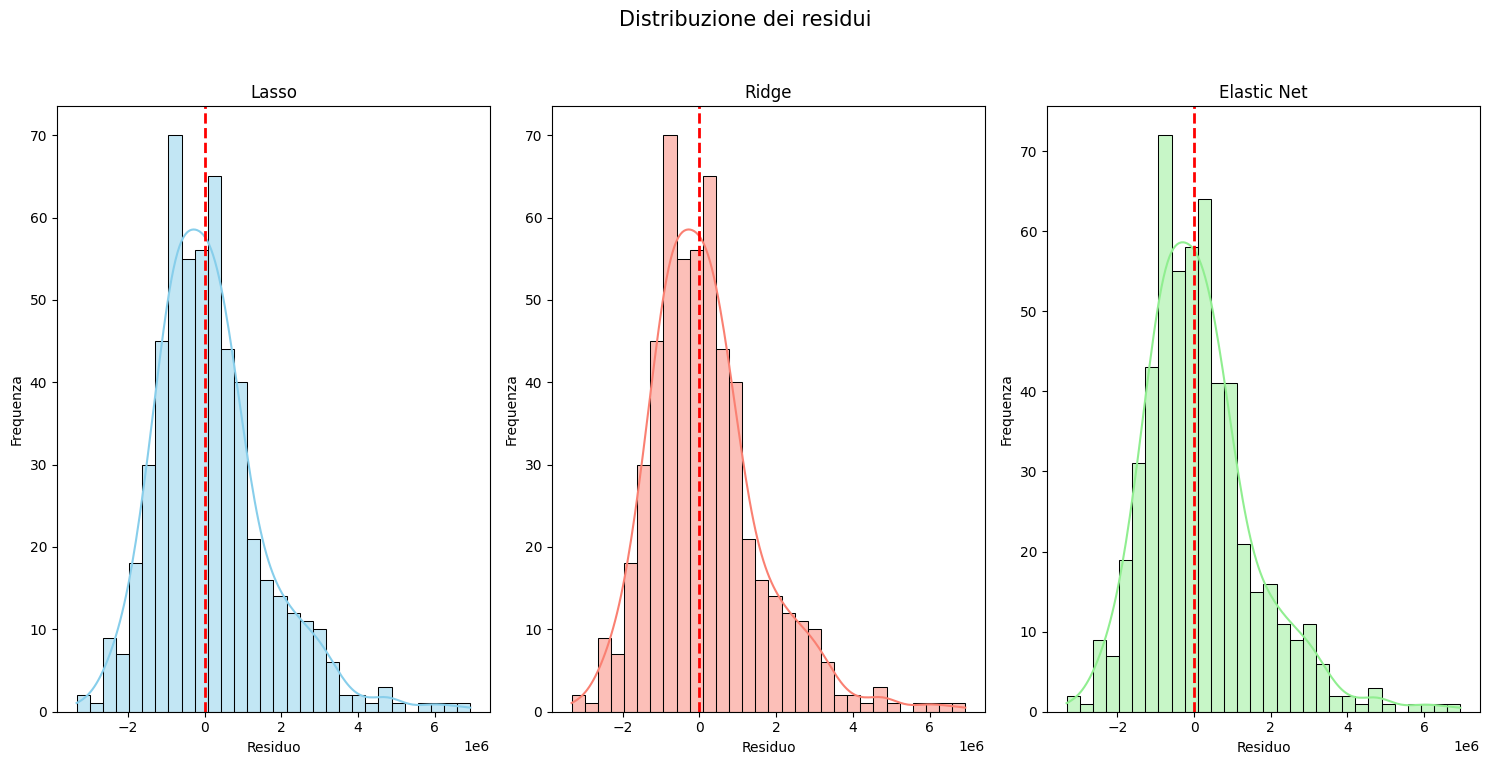

In [38]:
colors = ['skyblue', 'salmon', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()
residui = [diagram_dict[model][1] for model in diagram_dict.keys()]
models = [model for model in diagram_dict.keys()]

for ax, res, model, color in zip(axes, residui, models, colors):
    sns.histplot(res, kde=True, ax=ax, color=color, bins=30)
    #linea d'errore sullo zero
    ax.axvline(0, color='red', linestyle='--', linewidth=2)

    ax.set_title(model)
    ax.set_xlabel("Residuo")
    ax.set_ylabel("Frequenza")

fig.suptitle("Distribuzione dei residui", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Valutazione dei coefficienti dei modelli

Di seguito si passa a valutare i coefficenti dei modelli addestrati.

In [39]:
lasso_best.fit(X, y)
ridge_best.fit(X, y)
elastic_best.fit(X, y)

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [40]:
df_coef = pd.DataFrame(data={
    "Feature": df.drop(['price', 'furnishingstatus', 'basement', 'hotwaterheating', 'log_price'], axis=1).columns,
    "Lasso": lasso_best.coef_,
    "Ridge": ridge_best.coef_,
    "Elastic Net": elastic_best.coef_
})
df_coef.head(20)

,Feature,Lasso,Ridge,Elastic Net
0,area,521931.641912,521864.183563,518297.142626
1,bedrooms,126178.495562,126220.792283,128423.684495
2,bathrooms,534493.151707,534415.827477,530323.376289
3,stories,349104.556534,349064.170051,346931.671169
4,mainroad,166226.023095,166236.373924,166763.960485
5,guestroom,183924.805257,183917.613806,183525.872368
6,airconditioning,385516.314191,385485.629583,383843.837772
7,parking,275936.475330,275925.417806,275323.719717
8,prefarea,300964.715236,300932.498899,299218.742743


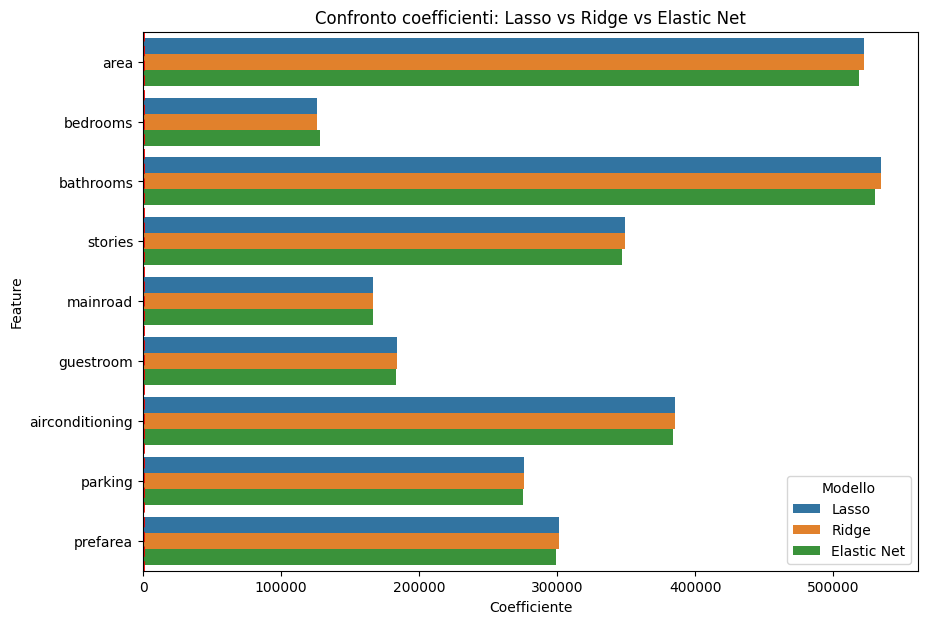

In [41]:
plt.figure(figsize=(10,7))
df_melted = df_coef.melt(id_vars='Feature', var_name='Modello', value_name= 'Coefficiente')

sns.barplot(data=df_melted, y='Feature', x='Coefficiente', hue='Modello')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Confronto coefficienti: Lasso vs Ridge vs Elastic Net')
plt.show()

### Analisi dei risultati

La prima evidenza riscontrata è che i modelli non performano bene sul dataset messo a disposizione, avendo tutti e 3 il medesimo comportamento sia in termini di metriche calcolate, che distribuzione di residui ed "importanza" data alle feature attraverso ai coefficienti assegnati.

Passando alla valutazione delle singole caratteristiche, per quanto riguarda i residui si può vedere (dal Grafico dei Residui) come più aumenta il valore della variabile predetta, maggiore è il residuo associato e questo è indice del fatto che il modello non riesce ad apprezzare i valori delle case "più costose".
Guardando al Grafico della Distribuzione dei Residui, si può vedere come per tutti i modelli ci sia una distribuzione a campana che però ha una coda a destra, indice del fatto che ci sono dei residui alti per le case a maggior valore.

Anche osservando il confronto tra i valori effettivi delle case e i valori predetti, si può notare come ci sia una tendenza a rimanere su di una diagonale dei punti indivduati, ma risulta anche esserci una notevole dispersione al crescere dei valori reali delle case (con il modello che sembra non arrivare proprio a calcolare certi range di prezzo).

## Analisi dei modelli utilizzando la log(price)

Viste le varie evidenze riscontrate, si può pensare di ripetere l'analisi usando come variabile target il logaritmo del prezzo, per fare in modo da ridurre l'influenza degli outliers e capire se i modelli riescono a migliorare la loro previsione.

Effetuando tale tipo di trasformazione, bisogna fare anche attenzione ad utilizzare dei valori di Alpha diversi nei modelli utilizzati, poiché cambiando la scala del target andrà a cambiare anche l'influenza dei valori di Alpha sulle operazioni di regolarizzazione. Tendenzialmente, si useranno valori di Alpha più piccoli.

In [42]:
X = df.drop(['price', 'furnishingstatus', 'basement', 'hotwaterheating', 'log_price'], axis=1).values
y = df['log_price'].values

In [43]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [44]:
X.shape

(545, 9)

In [45]:
y.shape

(545,)

### Implementazione dei modelli

In [46]:
alphas = [1.0, 0.1, 0.01, 0.001, 0.0001]

In [47]:
lasso_results = []

for a in alphas:

    lasso = Lasso(alpha = a)

    results = cross_validate(lasso, X, y, scoring=scoring_metrics, cv=5, return_train_score=True)

    lasso_results.append({
        "alpha":a,
        "Train MSE": -results['train_neg_mean_squared_error'].mean(),
        "Test MSE": -results['test_neg_mean_squared_error'].mean(),
        "Train R2": results['train_r2'].mean(),
        "Test R2": results['test_r2'].mean()
    })

df_lasso = pd.DataFrame(data=lasso_results)

In [48]:
ridge_results = []

for a in alphas:

    ridge = Ridge(alpha = a)

    results = cross_validate(ridge, X, y, scoring=scoring_metrics, cv=5, return_train_score=True)

    ridge_results.append({
        "alpha":a,
        "Train MSE": -results['train_neg_mean_squared_error'].mean(),
        "Test MSE": -results['test_neg_mean_squared_error'].mean(),
        "Train R2": results['train_r2'].mean(),
        "Test R2": results['test_r2'].mean()
    })

df_ridge = pd.DataFrame(data=ridge_results)

In [49]:
l1_values = [0.1, 0.3, 0.5, 0.7, 0.9]

elastic_results = []

for a in alphas:
    for l1 in l1_values:
        elastic = ElasticNet(alpha = a, l1_ratio = l1)
        results = cross_validate(elastic, X, y, scoring=scoring_metrics, cv=5, return_train_score=True)

        elastic_results.append({
            "alpha":a,
            "L1 Ratio": l1,
            "Train MSE": -results['train_neg_mean_squared_error'].mean(),
            "Test MSE": -results['test_neg_mean_squared_error'].mean(),
            "Train R2": results['train_r2'].mean(),
            "Test R2": results['test_r2'].mean()
        })

df_elastic = pd.DataFrame(data=elastic_results)

### Valutazione delle performance

Per confrontare le performance dei modelli si sceglie sempre lo stesso criterio, per cui si considerano i parametri dei modelli per cui si minimizza il MSE.

In [50]:
df_lasso[df_lasso['Test MSE'] == df_lasso['Test MSE'].min()]

,alpha,Train MSE,Test MSE,Train R2,Test R2
4,0.0001,0.045455,0.074417,0.630508,-7.073878


In [51]:
df_ridge[df_ridge['Test MSE'] == df_ridge['Test MSE'].min()]

,alpha,Train MSE,Test MSE,Train R2,Test R2
4,0.0001,0.045455,0.074346,0.630509,-7.076575


In [52]:
df_elastic[df_elastic['Test MSE'] == df_elastic['Test MSE'].min()]

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2
20,0.0001,0.1,0.045455,0.074356,0.630509,-7.076074


In [53]:
df_elastic['model_name'] = 'Elastic Net, L1 Ratio = 0.1, Alpha = 0.0001'
df_ridge['model_name'] = 'Ridge, Alpha = 0.0001'
df_lasso['model_name'] = 'Lasso, Alpha = 0.0001'
df_lasso_best = df_lasso[df_lasso['Test MSE'] == df_lasso['Test MSE'].min()]
df_ridge_best = df_ridge[df_ridge['Test MSE'] == df_ridge['Test MSE'].min()]
df_elastic_best = df_elastic[df_elastic['Test MSE'] == df_elastic['Test MSE'].min()]
df_evaluation = pd.concat([df_elastic_best, df_lasso_best, df_ridge_best])
df_evaluation.head()

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2,model_name
20,0.0001,0.1,0.045455,0.074356,0.630509,-7.076074,"Elastic Net, L1 Ratio = 0.1, Alpha = 0.0001"
4,0.0001,NaN,0.045455,0.074417,0.630508,-7.073878,"Lasso, Alpha = 0.0001"
4,0.0001,NaN,0.045455,0.074346,0.630509,-7.076575,"Ridge, Alpha = 0.0001"


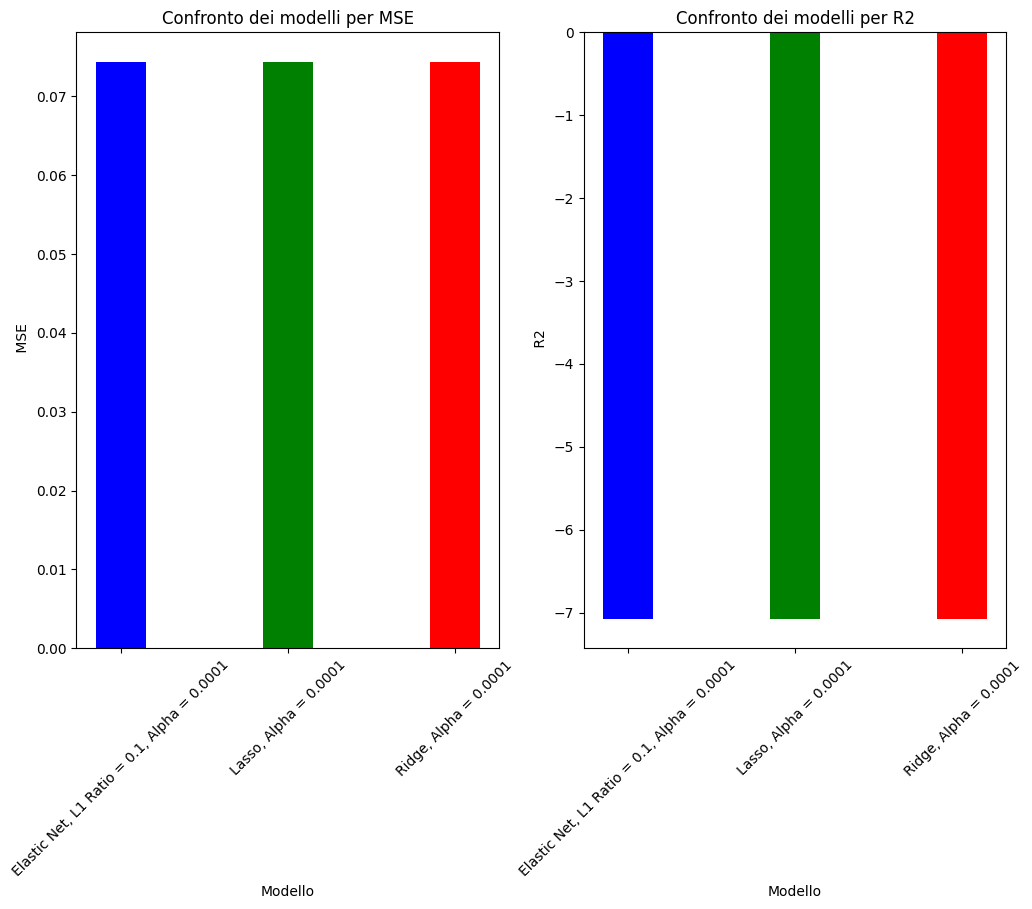

In [54]:
x = df_evaluation['model_name']
columns = df_evaluation[['Test MSE', 'Test R2']].columns
colors = ['blue', 'green', 'red']

fig, axes = plt.subplots(1, 2, figsize=[12, 8])
axes = axes.flatten()
for i, column in enumerate(columns):
    axes[i].bar(x, df_evaluation[column].values, width = 0.3, color = colors, label = column.strip('Test '))
    axes[i].set_xlabel('Modello')
    axes[i].set_ylabel(column.strip('Test'))
    axes[i].set_title(f"Confronto dei modelli per {column.strip('Test ')}")
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

In [55]:
#si definiscono i modelli con i parametri che ne massimizzano le performance
lasso_best = Lasso(alpha=0.0001)
ridge_best = Ridge(alpha=0.0001)
elastic_best = ElasticNet(alpha=0.0001, l1_ratio=0.1)

#calcolo dei residui
y_pred_lasso = cross_val_predict(lasso_best, X, y, cv=5)
residui_lasso = y - y_pred_lasso
y_pred_ridge = cross_val_predict(ridge_best, X, y, cv=5)
residui_ridge = y - y_pred_ridge
y_pred_elastic = cross_val_predict(elastic_best, X, y,cv=5)
residui_elastic = y - y_pred_elastic

#definizione del dizionario contenente i risultati
diagram_dict = {
    "Lasso": [y_pred_lasso, residui_lasso],
    "Ridge": [y_pred_ridge, residui_ridge],
    "Elastic Net": [y_pred_elastic, residui_elastic]
}

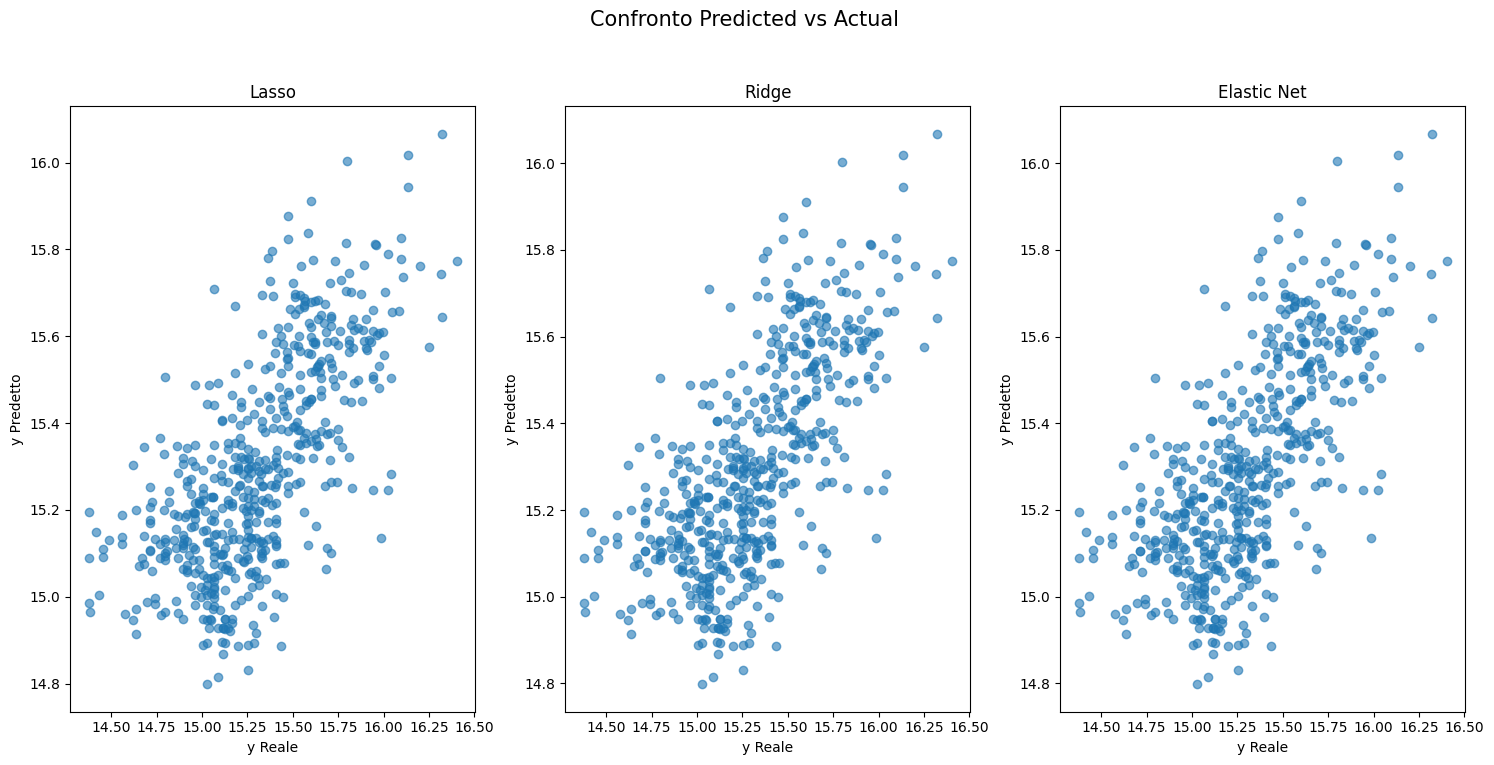

In [56]:
fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()

for i, model in enumerate(diagram_dict.keys()):
    axes[i].scatter(x=y, y=diagram_dict[model][0], alpha=0.6)
    axes[i].set_xlabel("y Reale")
    axes[i].set_ylabel("y Predetto")
    axes[i].set_title(f"{model}")

fig.suptitle("Confronto Predicted vs Actual", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

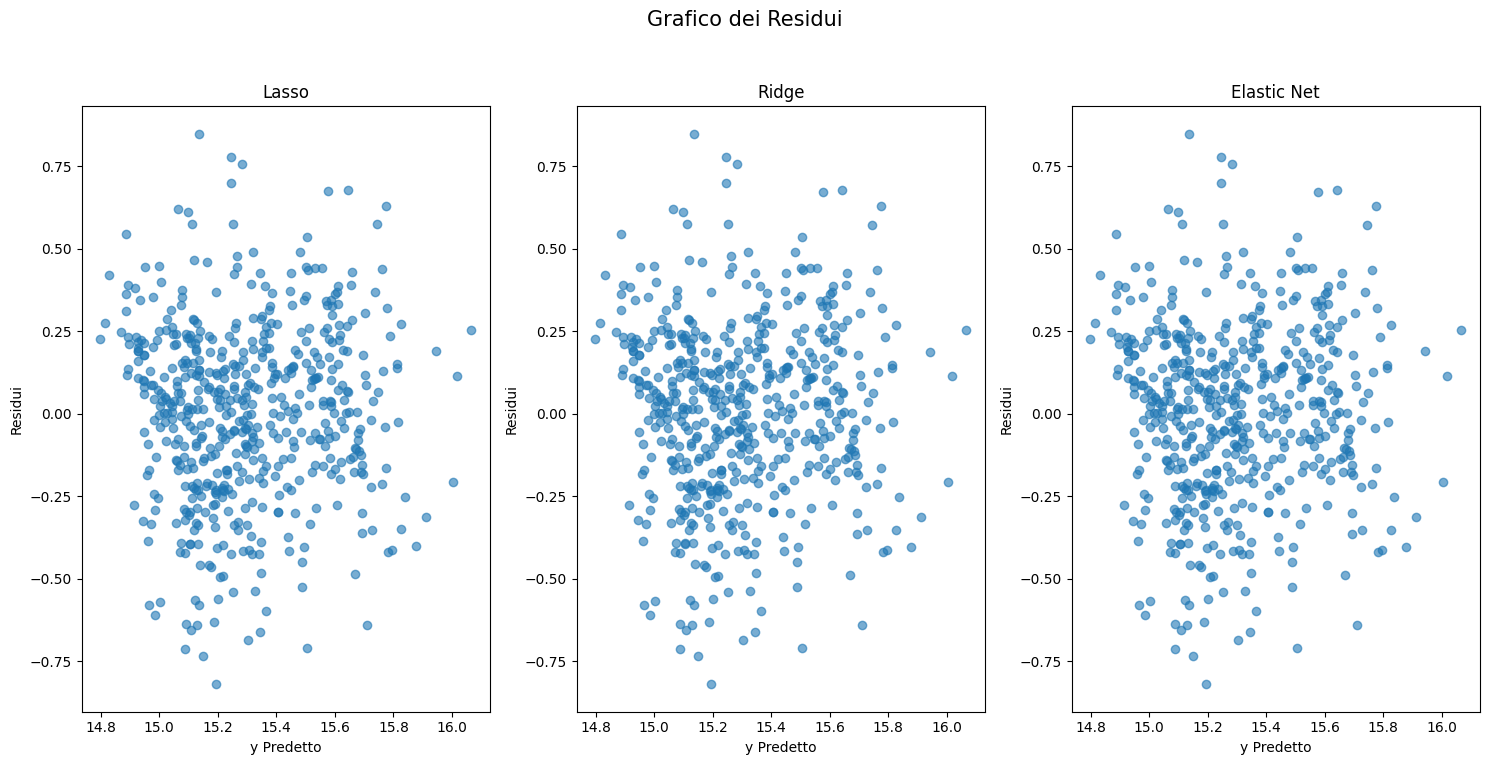

In [57]:
fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()


for i, model in enumerate(diagram_dict.keys()):
    axes[i].scatter(x=diagram_dict[model][0], y=diagram_dict[model][1], alpha=0.6)
    axes[i].set_xlabel("y Predetto")
    axes[i].set_ylabel("Residui")
    axes[i].set_title(f"{model}")

fig.suptitle("Grafico dei Residui", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

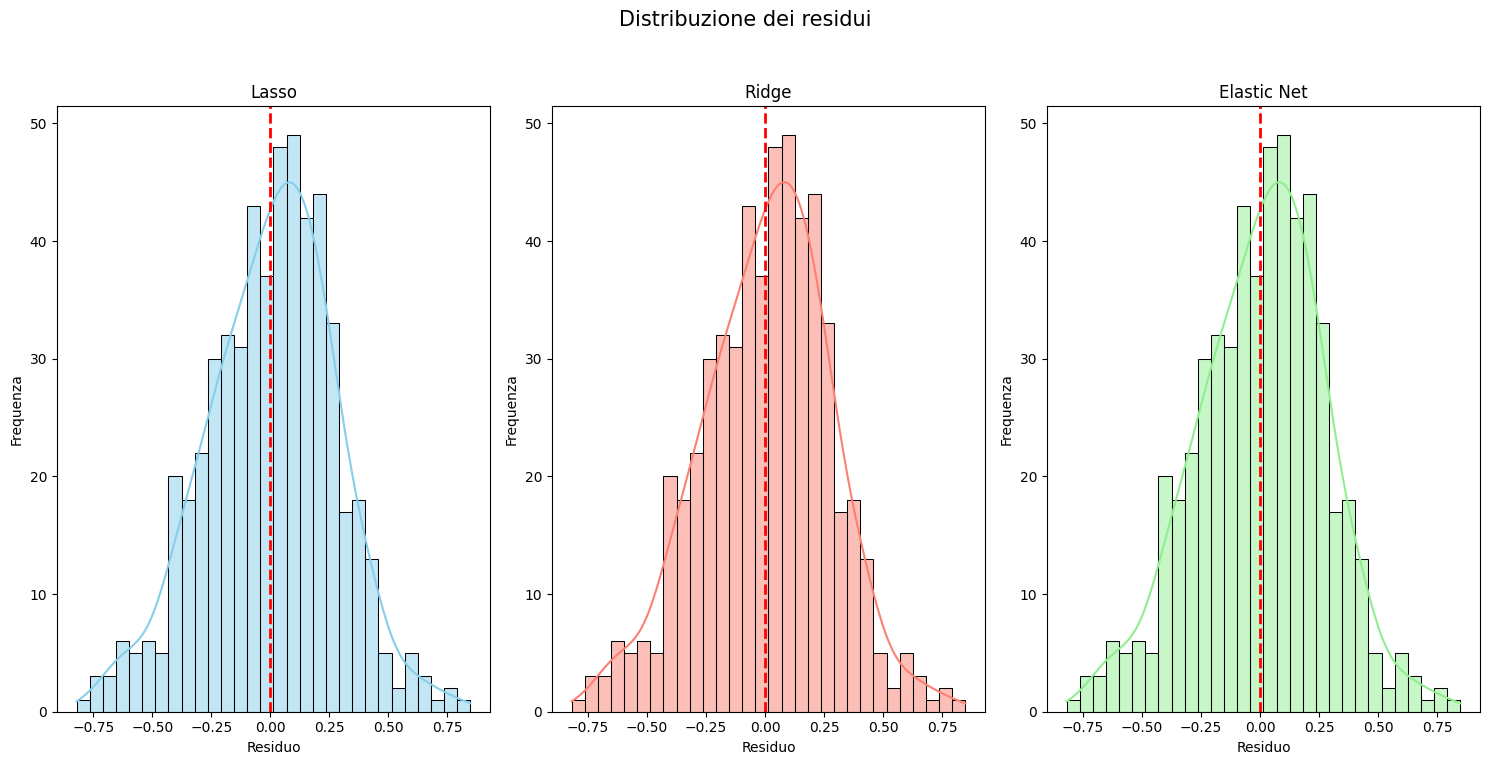

In [58]:
colors = ['skyblue', 'salmon', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()
residui = [diagram_dict[model][1] for model in diagram_dict.keys()]
models = [model for model in diagram_dict.keys()]

for ax, res, model, color in zip(axes, residui, models, colors):
    sns.histplot(res, kde=True, ax=ax, color=color, bins=30)
    #linea d'errore sullo zero
    ax.axvline(0, color='red', linestyle='--', linewidth=2)

    ax.set_title(model)
    ax.set_xlabel("Residuo")
    ax.set_ylabel("Frequenza")

fig.suptitle("Distribuzione dei residui", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [59]:
#addestramento per estrazione dei coefficienti delle feature
lasso_best.fit(X, y)
ridge_best.fit(X, y)
elastic_best.fit(X, y)

#definizione dei coefficienti
df_coef = pd.DataFrame(data={
    "Feature": df.drop(['price', 'furnishingstatus', 'basement', 'hotwaterheating', 'log_price'], axis=1).columns,
    "Lasso": lasso_best.coef_,
    "Ridge": ridge_best.coef_,
    "Elastic Net": elastic_best.coef_
})
df_coef.head(20)

,Feature,Lasso,Ridge,Elastic Net
0,area,0.105499,0.105515,0.105507
1,bedrooms,0.032967,0.033011,0.033009
2,bathrooms,0.091439,0.091475,0.091465
3,stories,0.066837,0.066880,0.066872
4,mainroad,0.046338,0.046394,0.046388
5,guestroom,0.044417,0.044483,0.044475
6,airconditioning,0.077926,0.077966,0.077959
7,parking,0.047901,0.047955,0.047950
8,prefarea,0.060436,0.060493,0.060484


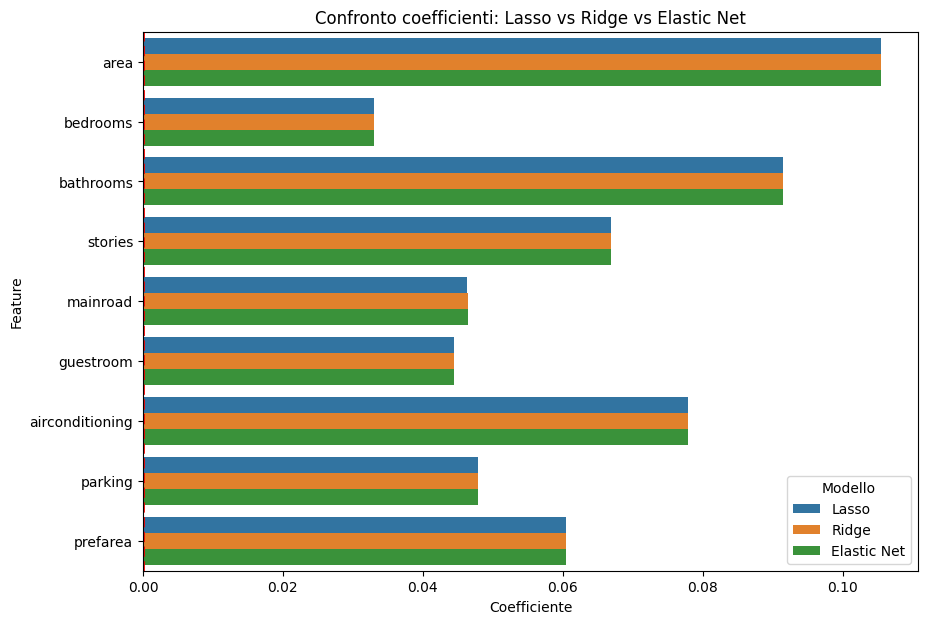

In [60]:
plt.figure(figsize=(10,7))
df_melted = df_coef.melt(id_vars='Feature', var_name='Modello', value_name= 'Coefficiente')

sns.barplot(data=df_melted, y='Feature', x='Coefficiente', hue='Modello')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Confronto coefficienti: Lasso vs Ridge vs Elastic Net')
plt.show()

### Analisi dei risultati

Analizzando i risultati si può vedere come da un lato ci sia un miglioramento della distribuzione dei residui e del raffronto tra predizione e residuo, in quanto lo scostamento adesso è più "omogeneo" e meno influenzato dai valori di prezzo elevati, mentre per la distribuzione si vede come adesso, per i 3 modelli sia più vicina ad una Gaussiana "standard".

Nonostante questo, i modelli ancora non performano bene sia in termini di R2, che risulta essere ancora negativo.

Un'ultima ottimizzazione che si potrebbe pensare di fare, è quella di garantire che i dati siano perfettamente mescolati quando si costruiscono i fold della cross validation usata per definire le metriche dei modelli e per il loro addestramento.

## Analisi dei risultati mediante utilizzo del KFold

Si procedere a ripetere le analisi utilizzando il KFold per ottenere delle divisioni dei dati "omogenei" per addestrare i modelli di Regressione, ed evitare che quindi i campioni su cui viene addestrato il modello siano troppo diversi da quelli su cui viene testato.

In [61]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Implementazione dei modelli

In [62]:
lasso_results = []

for a in alphas:

    lasso = Lasso(alpha = a)

    results = cross_validate(lasso, X, y, scoring=scoring_metrics, cv=kf, return_train_score=True)

    lasso_results.append({
        "alpha":a,
        "Train MSE": -results['train_neg_mean_squared_error'].mean(),
        "Test MSE": -results['test_neg_mean_squared_error'].mean(),
        "Train R2": results['train_r2'].mean(),
        "Test R2": results['test_r2'].mean()
    })

df_lasso = pd.DataFrame(data=lasso_results)

In [63]:
ridge_results = []

for a in alphas:

    ridge = Ridge(alpha = a)

    results = cross_validate(ridge, X, y, scoring=scoring_metrics, cv=kf, return_train_score=True)

    ridge_results.append({
        "alpha":a,
        "Train MSE": -results['train_neg_mean_squared_error'].mean(),
        "Test MSE": -results['test_neg_mean_squared_error'].mean(),
        "Train R2": results['train_r2'].mean(),
        "Test R2": results['test_r2'].mean()
    })

df_ridge = pd.DataFrame(data=ridge_results)

In [64]:
elastic_results = []

for a in alphas:
    for l1 in l1_values:
        elastic = ElasticNet(alpha = a, l1_ratio = l1)
        results = cross_validate(elastic, X, y, scoring=scoring_metrics, cv=kf, return_train_score=True)

        elastic_results.append({
            "alpha":a,
            "L1 Ratio": l1,
            "Train MSE": -results['train_neg_mean_squared_error'].mean(),
            "Test MSE": -results['test_neg_mean_squared_error'].mean(),
            "Train R2": results['train_r2'].mean(),
            "Test R2": results['test_r2'].mean()
        })

df_elastic = pd.DataFrame(data=elastic_results)

In [65]:
df_lasso[(df_lasso['Test R2'] == df_lasso['Test R2'].max()) | (df_lasso['Test MSE'] == df_lasso['Test MSE'].min())]

,alpha,Train MSE,Test MSE,Train R2,Test R2
3,0.001,0.047575,0.049819,0.655527,0.629505


In [66]:
df_ridge[(df_ridge['Test R2'] == df_ridge['Test R2'].max()) | (df_ridge['Test MSE'] == df_ridge['Test MSE'].min())]

,alpha,Train MSE,Test MSE,Train R2,Test R2
0,1.0,0.047571,0.049813,0.655556,0.629336


In [67]:
df_elastic[(df_elastic['Test R2'] == df_elastic['Test R2'].max()) | (df_elastic['Test MSE'] == df_elastic['Test MSE'].min())]

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2
10,0.01,0.1,0.047581,0.049796,0.655483,0.629758
11,0.01,0.3,0.047619,0.049830,0.655206,0.629944


Si nota un sostanziale miglioramento del valore di R2, che assume valori sia positivi che in un range accettabile.
Per i confronti delle perfomance dei modelli, si considerano sempre quelli con i parametri che minimizzano il valore di MSE.

In [68]:
df_elastic['model_name'] = 'Elastic Net, L1 Ratio = 0.1, Alpha = 0.01'
df_ridge['model_name'] = 'Ridge, Alpha = 1.0'
df_lasso['model_name'] = 'Lasso, Alpha = 0.001'
df_lasso_best = df_lasso[df_lasso['Test MSE'] == df_lasso['Test MSE'].min()]
df_ridge_best = df_ridge[df_ridge['Test MSE'] == df_ridge['Test MSE'].min()]
df_elastic_best = df_elastic[df_elastic['Test MSE'] == df_elastic['Test MSE'].min()]
df_evaluation = pd.concat([df_elastic_best, df_lasso_best, df_ridge_best])
df_evaluation.head()

,alpha,L1 Ratio,Train MSE,Test MSE,Train R2,Test R2,model_name
10,0.010,0.1,0.047581,0.049796,0.655483,0.629758,"Elastic Net, L1 Ratio = 0.1, Alpha = 0.01"
3,0.001,NaN,0.047575,0.049819,0.655527,0.629505,"Lasso, Alpha = 0.001"
0,1.000,NaN,0.047571,0.049813,0.655556,0.629336,"Ridge, Alpha = 1.0"


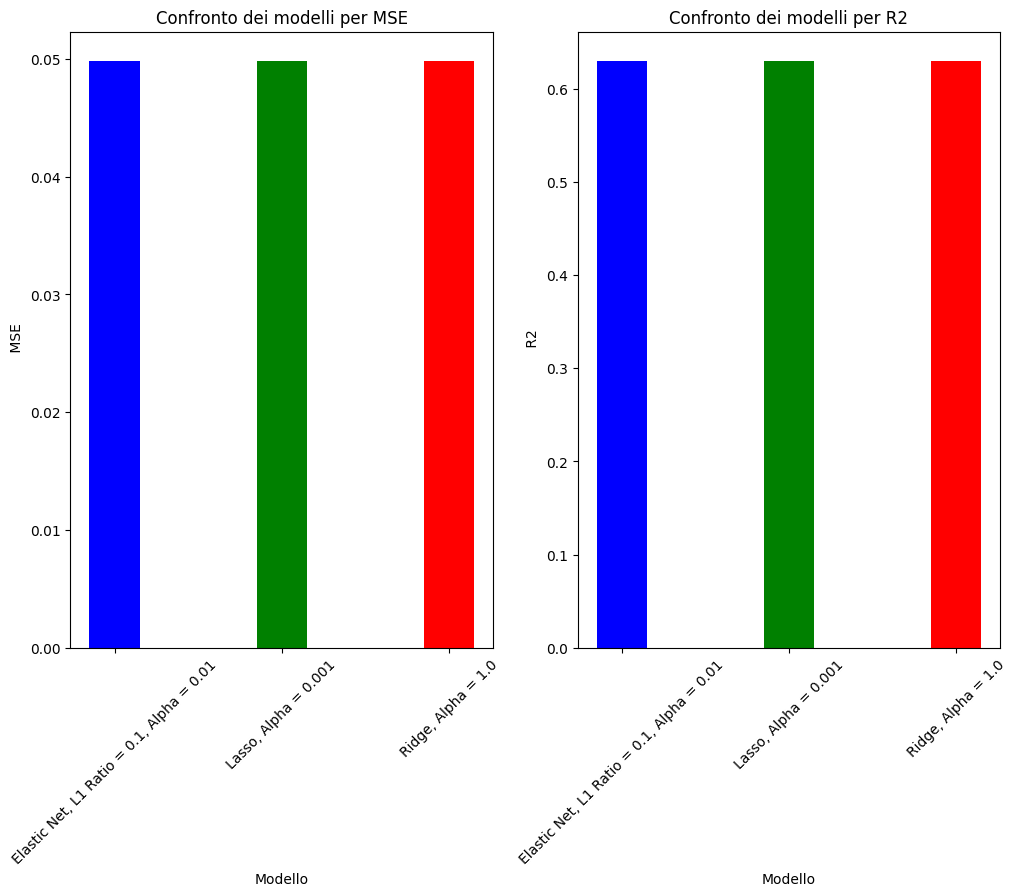

In [69]:
x = df_evaluation['model_name']
columns = df_evaluation[['Test MSE', 'Test R2']].columns
colors = ['blue', 'green', 'red']

fig, axes = plt.subplots(1, 2, figsize=[12, 8])
axes = axes.flatten()
for i, column in enumerate(columns):
    axes[i].bar(x, df_evaluation[column].values, width = 0.3, color = colors, label = column.strip('Test '))
    axes[i].set_xlabel('Modello')
    axes[i].set_ylabel(column.strip('Test'))
    axes[i].set_title(f"Confronto dei modelli per {column.strip('Test ')}")
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

In [70]:
#si definiscono i modelli con i parametri che ne massimizzano le performance
lasso_best = Lasso(alpha=0.001)
ridge_best = Ridge(alpha=1.0)
elastic_best = ElasticNet(alpha=0.01, l1_ratio=0.1)

#calcolo dei residui
y_pred_lasso = cross_val_predict(lasso_best, X, y, cv=kf)
residui_lasso = y - y_pred_lasso
y_pred_ridge = cross_val_predict(ridge_best, X, y, cv=kf)
residui_ridge = y - y_pred_ridge
y_pred_elastic = cross_val_predict(elastic_best, X, y,cv=kf)
residui_elastic = y - y_pred_elastic

#definizione del dizionario contenente i risultati
diagram_dict = {
    "Lasso": [y_pred_lasso, residui_lasso],
    "Ridge": [y_pred_ridge, residui_ridge],
    "Elastic Net": [y_pred_elastic, residui_elastic]
}

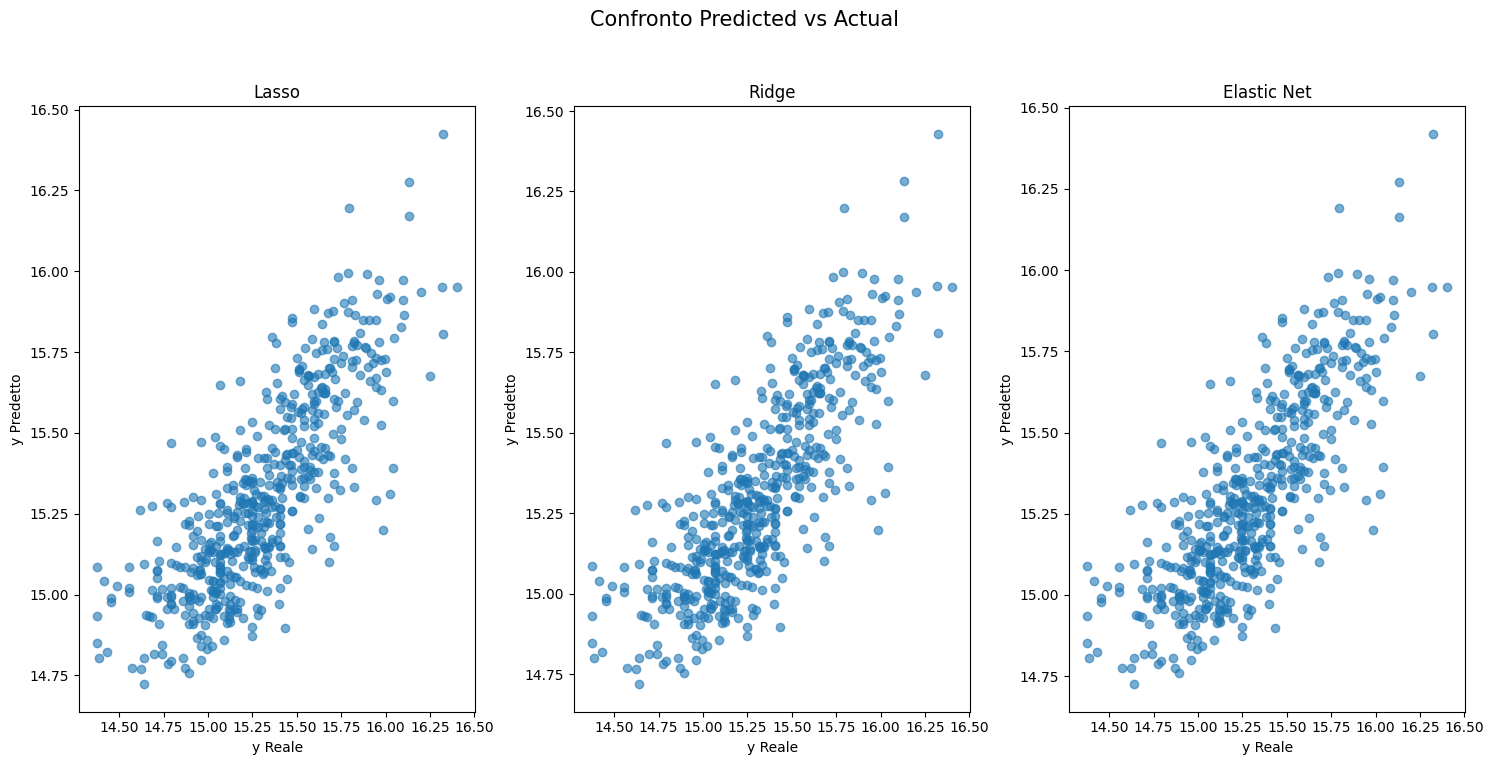

In [71]:
fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()

for i, model in enumerate(diagram_dict.keys()):
    axes[i].scatter(x=y, y=diagram_dict[model][0], alpha=0.6)
    axes[i].set_xlabel("y Reale")
    axes[i].set_ylabel("y Predetto")
    axes[i].set_title(f"{model}")

fig.suptitle("Confronto Predicted vs Actual", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

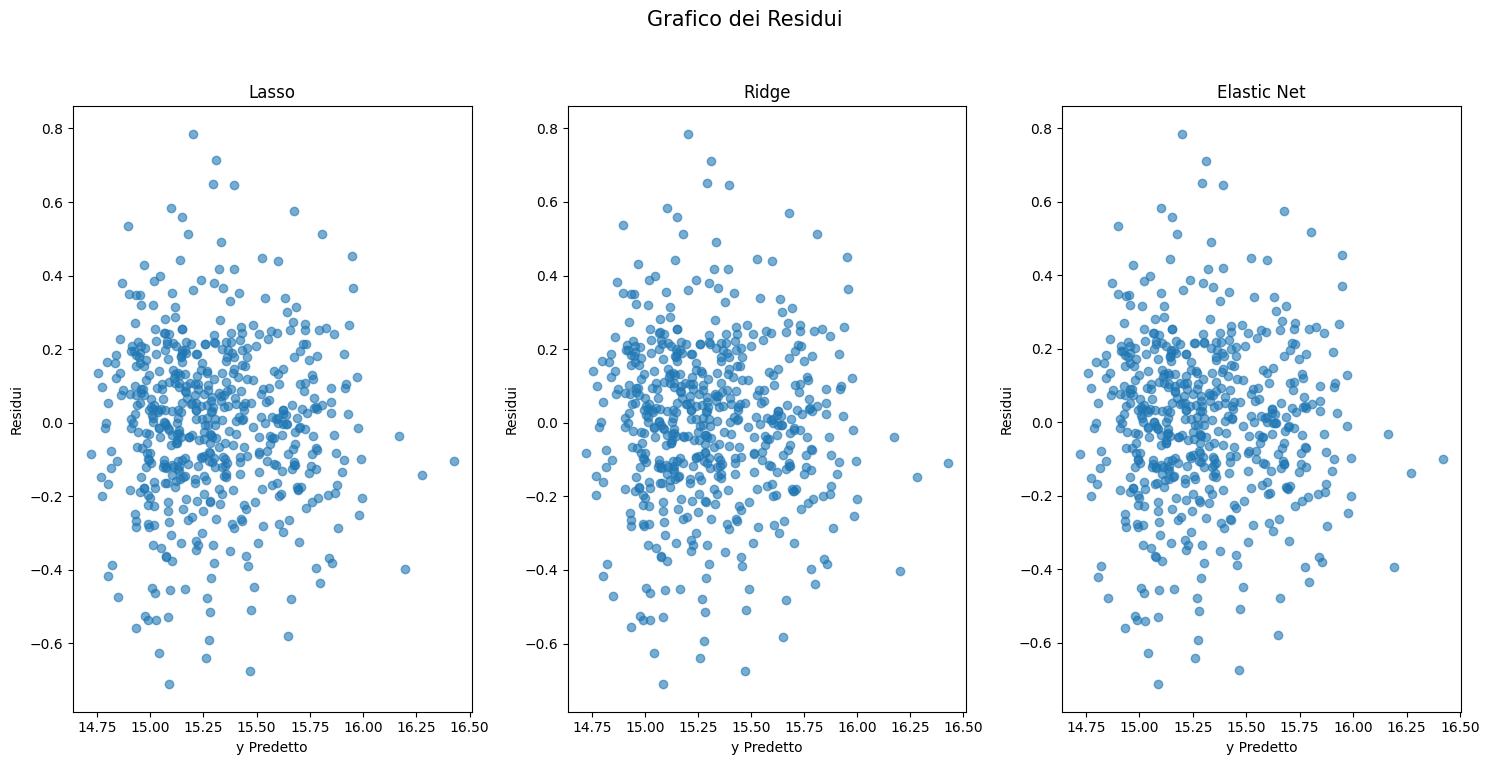

In [72]:
fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()


for i, model in enumerate(diagram_dict.keys()):
    axes[i].scatter(x=diagram_dict[model][0], y=diagram_dict[model][1], alpha=0.6)
    axes[i].set_xlabel("y Predetto")
    axes[i].set_ylabel("Residui")
    axes[i].set_title(f"{model}")

fig.suptitle("Grafico dei Residui", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

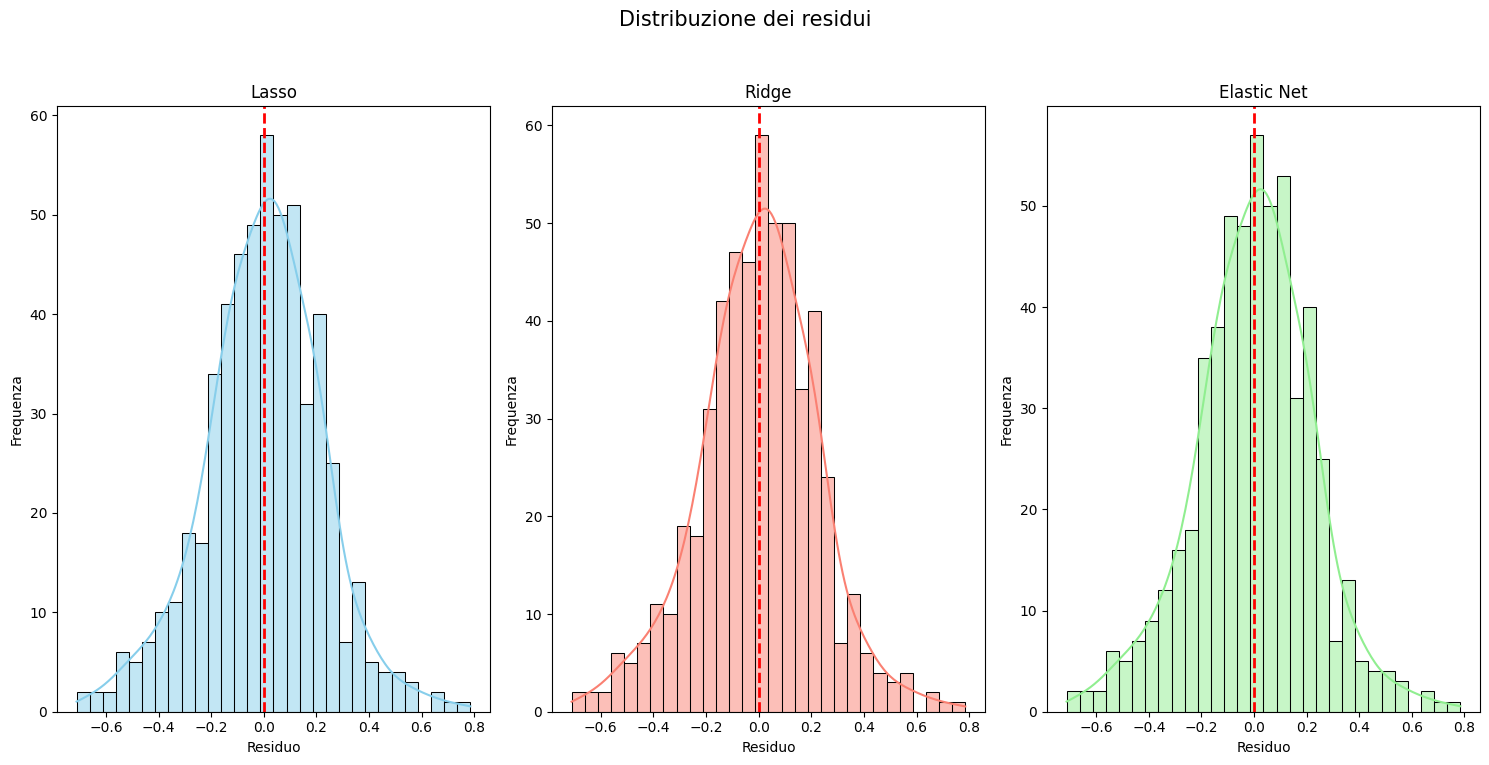

In [73]:
colors = ['skyblue', 'salmon', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize = [15, 8])
axes = axes.flatten()
residui = [diagram_dict[model][1] for model in diagram_dict.keys()]
models = [model for model in diagram_dict.keys()]

for ax, res, model, color in zip(axes, residui, models, colors):
    sns.histplot(res, kde=True, ax=ax, color=color, bins=30)
    #linea d'errore sullo zero
    ax.axvline(0, color='red', linestyle='--', linewidth=2)

    ax.set_title(model)
    ax.set_xlabel("Residuo")
    ax.set_ylabel("Frequenza")

fig.suptitle("Distribuzione dei residui", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [74]:
#addestramento per estrazione dei coefficienti delle feature
lasso_best.fit(X, y)
ridge_best.fit(X, y)
elastic_best.fit(X, y)

#definizione dei coefficienti
df_coef = pd.DataFrame(data={
    "Feature": df.drop(['price', 'furnishingstatus', 'basement', 'hotwaterheating', 'log_price'], axis=1).columns,
    "Lasso": lasso_best.coef_,
    "Ridge": ridge_best.coef_,
    "Elastic Net": elastic_best.coef_
})
df_coef.head(20)

,Feature,Lasso,Ridge,Elastic Net
0,area,0.105354,0.105379,0.104690
1,bedrooms,0.032570,0.033061,0.032811
2,bathrooms,0.091124,0.091358,0.090557
3,stories,0.066452,0.066811,0.066119
4,mainroad,0.045831,0.046384,0.045784
5,guestroom,0.043823,0.044454,0.043684
6,airconditioning,0.077568,0.077900,0.077245
7,parking,0.047411,0.047951,0.047393
8,prefarea,0.059922,0.060435,0.059644


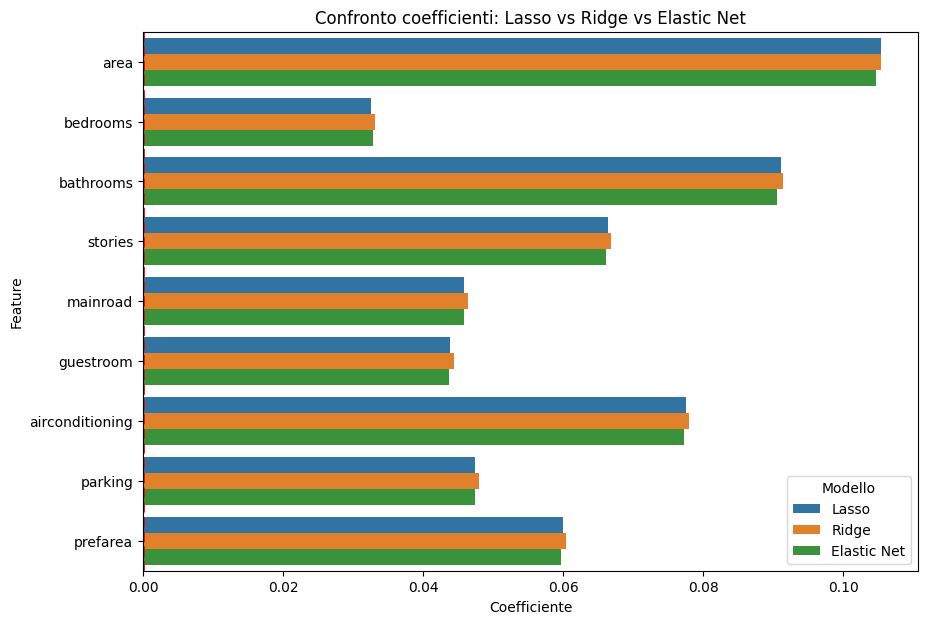

In [75]:
plt.figure(figsize=(10,7))
df_melted = df_coef.melt(id_vars='Feature', var_name='Modello', value_name= 'Coefficiente')

sns.barplot(data=df_melted, y='Feature', x='Coefficiente', hue='Modello')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Confronto coefficienti: Lasso vs Ridge vs Elastic Net')
plt.show()

### Analisi dei risultati

Finalmente è possibile vedere che forzando il mescolamento dei dati utilizzati per addestrare i modelli nella cross validation, i modelli ottengono dei valori di performance ottimali: probabilmente questo è indice del fatto che nei tentativi precedenti si andava effettivamente a configurare una situazione per la quale il fold su cui venivano testati i modelli aveva delle caratteristiche molto diverse rispetto a quelli usati per addestrarlo (ad esempio conteneva più immobili dal prezzo elevato o dal prezzo più basso). Inoltre, è possibile vedere come le performance tra training e test siano pressoché le stesse, evidenziando come non ci siano presenza di overfitting/underfitting.

In termini di aderenza delle previsioni ai valori reali, vediamo che i valori sono molto più "aderenti" quindi questo è indice di una drastica riduzione dell'errore dei modelli (si può vedere sia dal raffronto tra valori reali con predetti, dove i punti del grafico si distribuiscono quasi perfettamente su di una retta inclinata di 45°, sia nella distribuzione dei residui, dove vediamo che questi sono molto contenuti e la nuvola di punti è abbastanza omogenea).
Inoltre, la curva di distribuzione dei residui è molto vicina ad una Gaussiana Normale.

Per quanto riguarda i coefficienti associati alle feature, si vede come i modelli attribuiscono la maggiore influenza alla metratura degli appartamenti, seguita poi dal numero di bagni, dalla presenza dell'area condizionata e dalla zona in cui si trova l'appartamento.

## Conclusioni

In conclusione, gli esiti della seguente analisi mostrano come i modelli Lasso, Ridge ed Elastic Net possono essere utilizzati per trattare un dataset contenente una serie di caratteristiche utili a definire il prezzo degli appartamenti. Il loro utilizzo, però, prevede un trattamento dei dati anche rispetto alla variabile target di riferimento: infatti i risultati delle previsioni devono tenere in conto che il valore della predizione è relativo al logaritmo del prezzo e non direttamente al prezzo stesso. Inoltre, bisogna ricordarsi di stare attenti a garantire che durante la Cross Validatiom i fold su cui sono addestrati i modelli debbano essere tutti "rappresentativi" del mercato immobiliare.

Come si può vedere dalle analisi, non c'è un vero e proprio modello che "vince" sugli altri: tutti e 3 performano alla stessa maniera sul dataset a disposizione.